In [19]:
%matplotlib inline
import numpy as np
from scipy.optimize import root_scalar, minimize_scalar
from math import log, ceil
import ipywidgets as widgets
import matplotlib.pyplot as plt

# Raise error for divide by zero instead of warning
np.seterr(divide = 'raise')

class StabilityCalculator:
    """Calculator used to carry out the analytic operations for a single instance of a PARSimple system.

    Supplied with the parameters for a system modelled by PARSimple, this class computes the trajectory
    of the system and determines information for outputs, such as the domains, crossover points, 
    time in danger. etc.

    Attributes:
        I (float): The initial inexperienced population.
        E (float): The initial experienced population.
        N (int): The number of non-operational positions.
        P (int): The number of flying positions.
        R (int): The number of hours required to upgrade.
        g (float): The OTU graduate rate.
        a (float): The attrition rate.
        h (float): The rate of other experienced losses.
        rI (float): The max inexperienced training rate.
        rE (float): The max experienced mentoring rate.
        rY (float): The max overall flying rate.
    """    
    
    def __init__(self, I, E, N, P, R, g, a, h, rI, rE, rY): 
        """Initializes the instance of the calculator.

        Args:
            See class attributes.
        """
        self.I=I
        self.E=E
        self.N=N
        self.P=P
        self.R=R
        self.g=g
        self.a=a
        self.h=h
        self.rI=rI
        self.rE=rE
        self.rY=rY
    
    def run(self):
        """Main method of the class used to run the analysis until success or failure.

        Returns:
            time_in_danger (float): The time spent in domains other than mentee-limited.
            status (str): Indicates the end state of the system and cause of crash (if applicable).
            exceeds_P (bool): Indicates a transient violation of PML.
            tracking_info (dict): Contains the information needed to track the system through its
                crossover points. The keys are the times of the crossover points, the domains, 
                I (at the crossover point) and E (at the crossover point). The values are lists.
        """

        current_domain = self.determine_domain();
        time_in_danger = 0
        exceeds_P = False
        current_t = 0
        tracking_info = {'domains':[],'xover_points':[],'I':[],'E':[]}
        done = False 
        while not done:
            temp_E = self.E
            temp_I = self.I
            tracking_info['E'].append(temp_E)
            tracking_info['I'].append(temp_I)
            tracking_info['xover_points'].append(current_t)
            tracking_info['domains'].append(current_domain)
            
            if current_domain == 'mentee':
                t1 = self.find_mentee_yfr_crossover()
                t2 = self.find_mentee_mentor_crossover()
                t3 = self.find_mentee_position_crossover()
                t = min((i for i in (t1,t2,t3) if i>0), default=-1)
                if t == -1:
                    # Last domain, check if it violates PML in the future
                    if not exceeds_P and self.violates_P('mentee', temp_I, temp_E, current_t, -1, True):
                        exceeds_P = True
                    # Add steady state to tracking_info
                    Iss = self.g*self.R/self.rI
                    Ess = (self.g-self.h-self.a*self.N)/self.a
                    ss_time = self.steady_state_time(Iss, self.I, Ess, self.E, current_t)
                    current_t += ss_time
                    tracking_info['E'].append(Ess)
                    tracking_info['I'].append(Iss)
                    tracking_info['xover_points'].append(current_t)
                    tracking_info['domains'].append('Steady State')                    
                    done = True
                else:
                    self.E = self.E_mentee_lim(temp_E, temp_I, t)
                    self.I = self.I_mentee_lim(temp_E, temp_I, t)
                    if self.E < 0 or self.I < 0: # Do not move to next domain if population < 0
                        break
                    # Check for voilation of PML between current time and next crossover point
                    if not exceeds_P and self.violates_P('mentee', temp_I, temp_E, current_t, current_t+t, False):
                        exceeds_P = True
                    current_t += t
                    if t == t1:
                        current_domain = 'yfr'
                    elif t == t2:
                        current_domain = 'mentor'
                    else:
                        current_domain = 'position'
            elif current_domain == 'mentor':
                t1 = self.find_mentor_yfr_crossover()
                t2 = self.find_mentor_mentee_crossover()
                t3 = self.find_mentor_position_crossover()
                t = min((i for i in (t1,t2,t3) if i > 0), default=-1)
                if t == -1:
                    # Last domain, check if it violates PML in the future
                    if not exceeds_P and self.violates_P('mentor', temp_I, temp_E, current_t, -1, True):
                        exceeds_P = True
                    done = True
                    # Determine crash info if mentor-limited is the last domain
                    crashed_E_time = self.find_crash_mentor(self.E)
                    tracking_info['E'].append(0)
                    tracking_info['I'].append(self.I_mentor_lim(self.E, self.I, crashed_E_time))
                    tracking_info['xover_points'].append(crashed_E_time+current_t)
                    tracking_info['domains'].append('mentor')
                else:
                    self.E = self.E_mentor_lim(temp_E, temp_I, t)
                    self.I = self.I_mentor_lim(temp_E, temp_I, t)
                    # Do not move to next domain if population < 0.
                    # This also indicates a crash, add that info to tracking_info.
                    if self.E < 0 or self.I < 0: 
                        crashed_E_time = self.find_crash_mentor(temp_E)
                        tracking_info['E'].append(0)
                        tracking_info['I'].append(self.I_mentor_lim(temp_E, temp_I, crashed_E_time))
                        tracking_info['xover_points'].append(crashed_E_time+current_t)
                        tracking_info['domains'].append('Mentor-Limited Crash')
                        break
                    # Check for voilation of PML between current time and next crossover point
                    if not exceeds_P and self.violates_P('mentor', temp_I, temp_E, current_t, current_t+t, False):
                        exceeds_P = True
                    current_t += t
                    time_in_danger += t
                    if t == t1:
                        current_domain = 'yfr'
                    elif t == t2:
                        current_domain = 'mentee'
                    else:
                        current_domain = 'position'
            elif current_domain == 'yfr':
                t1 = self.find_yfr_mentee_crossover()
                t2 = self.find_yfr_mentor_crossover()
                t3 = self.find_yfr_position_crossover()
                t = min((i for i in (t1,t2,t3) if i > 0), default=-1)
                if t==-1:
                    # Last domain, check if it violates PML in the future
                    if not exceeds_P and self.violates_P('yfr', temp_I, temp_E, current_t, -1, True):
                        exceeds_P = True
                    done = True
                else:
                    self.E = self.E_yfr_lim(temp_E, t)
                    self.I = self.I_yfr_lim(temp_I, t)
                    if self.E < 0 or self.I < 0: # Do not move to next domain if population < 0.
                        break
                    # Check for voilation of PML between current time and next crossover point
                    if not exceeds_P and self.violates_P('yfr', temp_I, temp_E, current_t, current_t+t, False):
                        exceeds_P = True
                    current_t += t
                    time_in_danger += t
                    if t == t1:
                        current_domain = 'mentee' 
                    elif t == t2:
                        current_domain = 'mentor'
                    else:
                        current_domain = 'position'
            else:
                t1 = self.find_position_mentee_crossover()
                t2 = self.find_position_yfr_crossover()
                t3 = self.find_position_mentor_crossover()
                t = min((i for i in (t1,t2,t3) if i > 0), default=-1)
                if t==-1:
                    done = True
                    # If position-limited is the last domain, get crash info
                    crashed_E_time = self.find_crash_position(self.E, self.I)
                    tracking_info['E'].append(0)
                    tracking_info['I'].append(self.I_position_lim(self.I, crashed_E_time))
                    tracking_info['xover_points'].append(crashed_E_time+current_t)
                    tracking_info['domains'].append('Position-Limited Crash')
                else:
                    self.I = self.I_position_lim(temp_I, t)
                    self.E = self.E_position_lim(temp_E, temp_I, t)
                    if self.E < 0 or self.I < 0: # Do not move to next domain if population < 0.
                        break
                    current_t += t
                    time_in_danger += t
                    if t == t1:
                        current_domain = 'mentee' 
                    elif t == t2:
                        current_domain = 'yfr'
                    else:
                        current_domain = 'mentor'

        if current_domain == 'mentee':
            return time_in_danger, 'PASS', exceeds_P, tracking_info
        elif current_domain == 'mentor':
            return 500, 'FAIL_MENTOR', exceeds_P, tracking_info
        else:
            return 500, 'FAIL_POSITION', exceeds_P, tracking_info
        
                
    def check_passes_ss(self):
        """Returns whether or not the system passes the steady-state tests."""
        try:
            Iss = self.g*self.R/self.rI
            Ess = (self.g-self.h-self.a*self.N)/self.a
            # Rounding to prevent float comparison errors
            rounded_rIIss = round(self.rI*Iss, 10)
            rounded_rEEss = round(self.rE*Ess, 10)
            rounded_rY = round(self.rY, 10)
            rounded_rEPI = round(self.rE*(self.P-Iss), 10)
            return Iss>0 and Ess>0 and Iss+Ess<=self.P and\
                (rounded_rEEss>=rounded_rIIss or rounded_rEEss>=rounded_rY or rounded_rEEss>=rounded_rEPI) and\
                (rounded_rY>=rounded_rIIss or rounded_rY>=rounded_rEEss or rounded_rY>=rounded_rEPI) and\
                (rounded_rEPI>=rounded_rIIss or rounded_rEPI>=rounded_rEEss or rounded_rEPI>=rounded_rY)
        except:
            return False

    def check_passes_men_ic(self):
        """Returns whether or not the system passes the mentor-limited initial condition test."""
        
        # Rounding to prevent float comparison errors
        rounded_rII = round(self.rI*self.I, 10)
        rounded_rEE = round(self.rE*self.E, 10)
        rounded_rY = round(self.rY, 10)
        rounded_E = round(self.E, 10)
        rounded_I = round(self.I, 10)
        rounded_Ecrit = round(((self.h+self.a*self.N)/(self.rE/self.R-self.a)), 10)
        rounded_rEPI = round(self.rE*(self.P-self.I), 10)
        return (rounded_rEE>rounded_rII or rounded_rEE>rounded_rY or rounded_rEE>rounded_rEPI or rounded_E>=rounded_Ecrit)
    
    def check_passes_pos_ic(self):
        """Returns whether or not the system passes the position-limited initial condition test."""
        
        # Rounding to prevent float comparison errors
        rounded_rII = round(self.rI*self.I, 10)
        rounded_rEE = round(self.rE*self.E, 10)
        rounded_rY = round(self.rY, 10)
        rounded_E = round(self.E, 10)
        rounded_I = round(self.I, 10)
        rounded_rEPI = round(self.rE*(self.P-self.I), 10)
        return (rounded_rEPI>rounded_rII or rounded_rEPI>rounded_rEE or rounded_rEPI>rounded_rY or rounded_I < self.P-self.g*self.R/self.rE)
        
    def determine_domain(self):
        """Returns the domain of the system in the current state as a string."""
        rounded_mentee = round(self.rI*self.I, 10)
        rounded_mentor = round(self.rE*self.E, 10)
        rounded_yfr = round(self.rY, 10)
        rounded_position = round(self.rE*(self.P-self.I), 10)
        current_min = min(rounded_mentee, rounded_mentor, rounded_yfr, rounded_position)
        # If tied, we can observe the rate of change of I and E. If dI/dt>dE/dt, it is mentor-limited.
        if rounded_mentee == current_min and rounded_mentor == current_min:
            if self.g-self.rI/self.R*self.I > self.rI/self.R*self.I-self.h-self.a*self.E-self.a*self.N:
                return 'mentor'
            else:
                return 'mentee'
        # If tied, the system is position-limited if I is increasing, mentor-limited otherwise.
        elif rounded_mentor == current_min and rounded_position == current_min:
            if self.g-self.rE*self.E/self.R > 0:
                return 'position'
            else:
                return 'mentor'
        elif rounded_mentee == current_min:
            return 'mentee'
        elif rounded_mentor == current_min:
            return 'mentor'
        elif rounded_yfr == current_min:
            return 'yfr'
        else:
            return 'position'
        

    def find_yfr_mentee_crossover(self):
        """Returns the crossover point from YFR-limited to mentee-limited."""
        try:
            return (self.rY/self.rI-self.I)/(self.g-self.rY/self.R)
        except:
            return -1

    def find_yfr_mentor_crossover(self):
        """Returns the crossover point from YFR-limited to mentor-limited."""
        try:
            k=-self.rY+self.h*self.R+self.a*self.N*self.R
            log_arg = (self.rY*self.a*self.R+self.rE*self.k)/(self.rE*(self.E*self.a*self.R+k))
            return -log(log_arg)/self.a
        except:
            return -1

    def find_yfr_position_crossover(self):
        """Returns the crossover point from YFR-limited to position-limited."""
        k1 = self.I-self.P+self.g*self.R/self.rE
        try:
            return (self.rE*self.P-self.rY-self.rE*self.I)/(self.rE*(self.g-self.rY/self.R))
        except:
            return -1

    def find_mentee_yfr_crossover(self):
        """Returns the crossover point from mentee-limited to YFR-limited."""
        try:
            k1=self.I-self.g*self.R/self.rI
            log_arg = (self.rY-self.g*self.R)/(self.rI*self.k1)
            return -self.R*log(log_arg)/self.rI
        except:
            return -1

    def find_mentee_mentor_crossover(self):
        """Returns the crossover point from mentee-limited to mentor-limited."""
        try:
            func = lambda t: self.rI*self.I_mentee_lim(self.E, self.I, t)- self.rE*self.E_mentee_lim(self.E, self.I, t)
            # To use root_scalar, we need a bracket that evaluates to opposite signs at each end.
            t_sol = root_scalar(func, bracket=[0.01, self.get_bracket_upper(func)])
            return t_sol.root
        except:
            return -1

    def find_mentee_position_crossover(self):
        """Returns the crossover point from mentee-limited to position-limited."""
        try:
            k1=self.I-self.g*self.R/self.rI
            log_arg = (self.rE*self.P/(self.rI+self.rE)-self.g*self.R/self.rI)/k1
            return -self.R/self.rI*log(log_arg)
        except:
            return -1

    def find_mentor_yfr_crossover(self):
        """Returns the crossover point from mentor-limited to YFR-limited."""
        k1=self.E-(self.h+self.a*self.N)/(self.rE/self.R-self.a)
        k2=self.I+k1/(1-self.a*self.R/self.rE)
        try:
            log_arg = (self.rY-(self.rE*(self.h+self.a*self.N))/(self.rE/self.R-self.a))/(self.rE*k1)
            return log(log_arg)/(self.rE/self.R-self.a)
        except:
            return -1

    def find_mentor_mentee_crossover(self):
        """Returns the crossover point from mentor-limited to mentee-limited."""
        try:
            func = lambda t: self.rE*self.E_mentor_lim(self.E, self.I, t)-self.rI*self.I_mentor_lim(self.E, self.I, t)
            # To use root_scalar, we need a bracket that evaluates to opposite signs at each end.
            t_sol = root_scalar(func, bracket=[0.01, self.get_bracket_upper(func)])
            return t_sol.root
        except:
            return -1

    def find_mentor_position_crossover(self):
        """Returns the crossover point from mentor-limited to position-limited."""
        try:
            func = lambda t: self.E_mentor_lim(self.E, self.I, t)+self.I_mentor_lim(self.E, self.I, t)-self.P
            # To use root_scalar, we need a bracket that evaluates to opposite signs at each end.
            t_sol = root_scalar(func, bracket=[0.01, self.get_bracket_upper(func)])
            return t_sol.root
        except:
            return -1
            
    def find_position_mentee_crossover(self):
        """Returns the crossover point from position-limited to mentee-limited."""
        k1 = self.I-self.P+self.g*self.R/self.rE
        try:
            log_arg = (self.g*self.R*(1+self.rI/self.rE)-self.rI*self.P)/(k1*(self.rI+self.rE))
            return self.R/self.rE*log(log_arg)
        except:
            return -1

    def find_position_mentor_crossover(self):
        """Returns the crossover point from position-limited to mentor-limited."""
        try:
            func = lambda t: self.P-self.E_position_lim(self.E, self.I, t)-self.I_position_lim(self.I, t)
            # To use root_scalar, we need a bracket that evaluates to opposite signs at each end.
            t_sol = root_scalar(func, bracket=[0.01, self.get_bracket_upper(func)])
            return t_sol.root
        except:
            return -1
    
    def find_position_yfr_crossover(self):
        """Returns the crossover point from position-limited to YFR-limited."""
        k1 = self.I-self.P+self.g*self.R/self.rE
        try:
            log_arg = (self.g*self.R-self.rY)/(self.rE*k1)
            return self.R/self.rE*log(log_arg)
        except:
            return -1   
    
    def get_bracket_upper(self, func):
        """Returns a value of t to use as an upper-bound on the bracket for the root_scalar function.

        Args:
            func (function): The function for which a bracket value needs to be found.
        """
        i = 1
        done = False
        # Checking for sign change within next 40 years. The functions will all initially
        # be negative (by construction), so we are looking for a positive value.
        while i < 2080 and done == False:
            if func(i) > 0:
                done = True
            i+=1
        return i
    
    def E_mentor_lim(self, E, I, t):
        """Returns the value of E in the mentor-limited domain.

        Args:
            E (float): The initial value of E.
            I (float): The initial value of I.
            t (float): The time at which to calculate the new value of E.
        """
        try:
            k1=E-(self.h+self.a*self.N)/(self.rE/self.R-self.a)
            k2=I+k1/(1-self.a*self.R/self.rE)
            return k1*np.exp((self.rE/self.R-self.a)*t)+(self.h+self.a*self.N)/(self.rE/self.R-self.a)
        except ZeroDivisionError:
            return 10000000
    
    def I_mentor_lim(self, E, I, t):
        """Returns the value of I in the mentor-limited domain.

        Args:
            E (float): The initial value of E.
            I (float): The initial value of I.
            t (float): The time at which to calculate the new value of I.
        """
        try:
            k1=E-(self.h+self.a*self.N)/(self.rE/self.R-self.a)
            k2=I+k1/(1-self.a*self.R/self.rE)
            return -k1/(1-self.a*self.R/self.rE)*np.exp((self.rE/self.R-self.a)*t)+\
                    ((-self.h-self.a*self.N)/(1-self.a*self.R/self.rE)+self.g)*t+k2
        except ZeroDivisionError:
            return 10000000
    
    def E_mentee_lim(self, E, I, t):
        """Returns the value of E in the mentee-limited domain.

        Args:
            E (float): The initial value of E.
            I (float): The initial value of I.
            t (float): The time at which to calculate the new value of E.
        """
        try:
            k1=I-self.g*self.R/self.rI
            k2=E+(self.rI/(self.rI-self.a*self.R))*k1-(self.g-self.h-self.a*self.N)/self.a
            return -self.rI/(self.rI-self.a*self.R)*k1*np.exp(-self.rI*t/self.R)+k2*np.exp(-self.a*t)+\
                    (self.g-self.h-self.a*self.N)/self.a
        except ZeroDivisionError:
            return 10000000
    
    def I_mentee_lim(self, E, I, t):
        """Returns the value of I in the mentee-limited domain.

        Args:
            E (float): The initial value of E.
            I (float): The initial value of I.
            t (float): The time at which to calculate the new value of I.
        """
        try:
            k1=I-self.g*self.R/self.rI
            k2=E+(self.rI/(self.rI-self.a*self.R))*k1-(self.g-self.h-self.a*self.N)/self.a
            return k1*np.exp(-self.rI*t/self.R)+self.g*self.R/self.rI
        except ZeroDivisionError:
            return 10000000
    
    def E_yfr_lim(self, E, t):
        """Returns the value of E in the YFR-limited domain.

        Args:
            E (float): The initial value of E.
            I (float): The initial value of I.
            t (float): The time at which to calculate the new value of E.
        """
        try:
            k=-self.rY+self.h*self.R+self.a*self.N*self.R
            return ((E*self.a*self.R+k)*np.exp(-self.a*t)-k)/(self.a*self.R)
        except ZeroDivisionError:
            return 10000000
    
    def I_yfr_lim(self, I, t):
        """Returns the value of I in the YFR-limited domain.

        Args:
            E (float): The initial value of E.
            I (float): The initial value of I.
            t (float): The time at which to calculate the new value of I.
        """
        try:
            return I+(self.g-self.rY/self.R)*t
        except ZeroDivisionError:
            return 10000000

    def I_position_lim(self, I, t):
        """Returns the value of I in the position-limited domain.

        Args:
            E (float): The initial value of E.
            t (float): The time at which to calculate the new value of I.
        """
        try:
            k1 = I-self.P+self.g*self.R/self.rE
            return k1*np.exp(self.rE/self.R*t)+self.P-self.g*self.R/self.rE
        except ZeroDivisionError:
            return 10000000

    def E_position_lim(self, E, I, t):
        """Returns the value of E in the position-limited domain.

        Args:
            E (float): The initial value of E.
            I (float): The initial value of I.
            t (float): The time at which to calculate the new value of E.
        """
        try:
            k1 = I-self.P+self.g*self.R/self.rE
            k2 = E+k1/(1+self.a*self.R/self.rE)-(self.g-self.h-self.a*self.N)/self.a
            return -k1/(1+self.a*self.R/self.rE)*np.exp(self.rE/self.R*t)+k2*np.exp(-self.a*t)+(self.g-self.h-self.a*self.N)/self.a
        except ZeroDivisionError:
            return 10000000

    def violates_P(self, domain, I, E, lower, upper, end):
        """Returns whether the system will violate PML within a timeframe.

        There is a transient violation of PML if P-I-E < 0 for some t in [t1,t2].
        Therefore, we can just check that the minimum of P-I-E < 0.
        
        Args:
            I (float): The initial value of I.
            E (float): The initial value of E.
            lower (float): The start time.
            upper (float): The end time.
            end (bool): Whether we are looking for a violation in the end state or not.
        """
        if domain == 'mentee':
            func = lambda t: self.P-self.I_mentee_lim(E, I, t)-self.E_mentee_lim(E, I, t)
        elif domain == 'mentor':
            func = lambda t: self.P-self.I_mentor_lim(E, I, t)-self.E_mentor_lim(E, I, t)
        else: # YFR-limited. No need to check position-limited as it violates by definition.
            func = lambda t: self.P-self.I_yfr_lim(I, t)-self.E_yfr_lim(E, t)

        if end:
            i = lower
            violates = False
            # Checking for sign change within next 40 years
            while i < lower+2080 and violates == False:
                if func(i) < 0:
                    violates = True
                i+=1
            return violates
        else:
            minimum = minimize_scalar(func, bounds=(lower,upper)).fun
            return minimum < 0;

    def find_crash_mentor(self, E):
        """Returns the time at which E will crash in the mentor-limited domain.

        Args:
            E (float): The current value of E.
        """
        try:
            k1=E-(self.h+self.a*self.N)/(self.rE/self.R-self.a)
            return log(-(self.h+self.a*self.N)/(k1*(self.rE/self.R-self.a)))/(self.rE/self.R-self.a)
        except:
            return -1

    def find_crash_position(self, E, I):
        """Returns the time at which E will crash in the mentor-limited domain.

        The system crashes if E=0, but equivalently if I=P.
        
        Args:
            I (float): The current value of I.
        """
        try:
            # Add a minus (-) because get_bracket_upper() searches for positive values
            func = lambda t: -self.E_position_lim(E, I, t)
            # To use root_scalar, we need a bracket that evaluates to opposite signs at each end.
            t_sol = root_scalar(func, bracket=[0.01, self.get_bracket_upper(func)])
            return t_sol.root
        except:
            return -1

    def steady_state_time(self, Iss, I, Ess, E, last_t):
        """Returns the time at which the system will reach steady state.
        
        In theory, this never happens. However, for in practice, we will consider
        that the system reaches steady state when |Iss-I| < 1 and |Ess-E| < 1.
        
        Args:
            Iss (float): The mentee population steady-state value.
            Ess (float): The mentor population steady-state value.
            last_t (float): The time of the last crossover point.
            Others: See StabilityCalculator args.
        """
        k1 = I-Iss
        k2=E+(self.rI/(self.rI-self.a*self.R))*k1-(self.g-self.h-self.a*self.N)/self.a
        t1 = -1
        t2 = -1
        
        if abs(Iss-I)<1:
            t1 = 0
        elif Iss > I:
            t1 = -self.R*log(-0.05*Iss/k1)/self.rI
        else:
            t1 = -self.R*log(0.05*Iss/k1)/self.rI
            
        if abs(Ess-E)<1:
            t2 = 0
        elif Ess > E:
            func = lambda t: Ess-(-self.rI/(self.rI-self.a*self.R)*k1*np.exp(-self.rI*t/self.R)+k2*np.exp(-self.a*t)+\
                    (self.g-self.h-self.a*self.N)/self.a)-0.05*Ess
            t2 = root_scalar(func, bracket=[0, self.get_threshold(func, last_t)]).root
        else:
            func = lambda t: (-self.rI/(self.rI-self.a*self.R)*k1*np.exp(-self.rI*t/self.R)+k2*np.exp(-self.a*t)+\
                    (self.g-self.h-self.a*self.N)/self.a)-0.05*Ess-Ess
            t2 = root_scalar(func, bracket=[0, self.get_threshold(func, last_t)]).root
        
        return max(t1,t2)
    
    def get_threshold(self, func, last_t):
        """Returns an upper bracket for use in steady_state_time().
    
        Calculate when the function will change signs. In our case,
        it is used to find when Ess-E-1 will change signs.
        """
        i = last_t
        done = False
        # Checking for sign change within next 40 years
        while i < last_t+10000 and done == False:
            if func(i) < 0:
                done = True
            i+=1
        return i
        
    

In [2]:
def calc_u(I, E, P, R, rI, rE, rY):
    """Returns the upgrade rate.

    Args:
        See StabilityCalculator args.
    """
    current_min = min(rI*I, rE*E, rY, rE*(P-I))
    if rI*I == current_min:
        return rI/R*I
    elif rE*E == current_min:
        return rE/R*E
    elif rY == current_min:
        return rY/R
    else:
        return rE/R*(P-I)

def get_vector_coordinates(I, E, N, P, R, g, a, h, rI, rE, rY):
    """Returns the derivatives of I and E.

    Args:
        See StabilityCalculator args.
    """
    u = calc_u(I, E, P, R, rI, rE, rY)
    x = g-u
    y = u-h-a*E-a*N
    return x, y

# PARSimple "What If?" Analytic Tool
Welcome to the PARSimple "What If?" Analytic Tool. This tool allows you to modify the parameters to PARSimple and observe several outputs, such as areas of system sustainability, areas of transient voilation of PML, times in danger zones and the tracking of a specific system. The following image shows the flow diagram of the system and the subsequent table describes the variables used in this tool.

![PARSimple Flow Diagram](flow_diag.png "PARSimple Flow Diagram")

| Variable | Description                                         |
|----------|-----------------------------------------------------|
| I        | Initial inexperienced population                    |
| E        | Initial experienced population                      |
| N        | Non-operational positions                           |
| P        | Number of flying positions                          |
| R        | Hours required to upgrade                           |
| g        | OTU graduate rate (people/year)                     |
| h        | Other experienced population losses (people/year)   |
| a        | Attrition rate (/year)                              |
| rI       | Max inexperienced training rate (hours/year/mentee) |
| rE       | Max experienced mentoring rate (hours/year/mentee)  |
| rY       | rY: Max overall flying rate (YFR) (hours/year)       |

### Important Notes
- Note that if you are inputting the parameters with the keyboard instead of using the slider, you **MUST** press ENTER after inputting each parameter to ensure that the change will be reflected. If done successfully, the slider should move once ENTER is pressed.
- The execution of an output generation instance is finished once the *Run Interact* button returns to being clickable. This is important to notice, as it is possible that in certain circumstances, changing some of the variables will not affect the output.

***



### Important Metrics Based on Initial Experienced and Inexperienced Pilots

This will generate the 5 plots of I vs E with differing information.
1. The final system sustainability.
2. The change in I and E as a vector field, colour-coded to also show the final system sustainability.
3. The times in danger zones (danger zones are defined as any domain other than mentee-limited).
4. The initial domains of the system.
5. The areas where the system will violate PML at some point during execution.

In [109]:
%matplotlib inline
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap, Normalize


def plot_outputs(N=25, P=30, R=250, g=4, a=0.07,
                     h=1, rI=144, rE=144, rY=10000):
    """Function used to plot the main outputs of the analytic tool.

    Args:
        See StabilityCalculator args.
    """
    fig, ((ax0,ax1),(ax2,ax3),(ax4,ax5)) = plt.subplots(3,2, figsize=(20,30))

    x,y = np.meshgrid(np.linspace(0,P+1,P+1),np.linspace(0,P+1,P+1)) 
    u = np.zeros(x.shape) # dI/dt for vector field
    v = np.zeros(y.shape) # dE/dt for vector field
    times = np.zeros([P+1,P+1]) # Times in danger
    color_vals = np.zeros([P+1,P+1]) # Color values for end state and vector field
    color_vals_2 = np.zeros([P+1,P+1]) # Color values for transient PML violation
    color_vals_init_domain = np.zeros([P+1,P+1]) # Color values for initial domain plot
    
    for e in range(0, P+1):
        for i in range(0, P+1):
            # Update vector field
            x_val, y_val = get_vector_coordinates(i, e, N, P, R, g/52, a/52, h/52, rI/52, rE/52, rY/52)
            u[e,i] = x_val
            v[e,i] = y_val
            
            calculator = StabilityCalculator(i, e, N, P, R, g/52, a/52, h/52, rI/52, rE/52, rY/52)
            init_domain = calculator.determine_domain()
            time_in_danger, status, exceeds_P, _ = calculator.run()

            times[e,i] = time_in_danger

            # Update colors for end state and vector field
            c_value = None
            if status == 'PASS':
                c_value = 0
            elif status == 'FAIL_MENTOR':
                c_value = 1
            else:
                c_value = 2
            color_vals[e,i] = c_value

            # Update colors for PML violation
            c_value_2 = None
            if status != 'PASS':
                c_value_2 = 3
            else:
                if not exceeds_P:
                    c_value_2 = 1
                else:
                    c_value_2 = 2
            color_vals_2[e,i] = c_value_2

            # Update colors for init domain plot
            c_value_dom = None
            if init_domain == 'mentee':
                c_value_dom = 0
            elif init_domain == 'mentor':
                c_value_dom = 1
            elif init_domain == 'yfr':
                c_value_dom = 2
            else:
                c_value_dom = 3
            color_vals_init_domain[e,i] = c_value_dom
                
    try:
        iss = g*R/rI
        ess = (g-h-a*N)/a
    except:
        iss = 0
        ess= 0

    # Plot steady-state
    ax0.plot(iss,ess,'k*', markersize=10) 
    ax1.plot(iss,ess,'k*', markersize=10)
    ax2.plot(iss,ess,'k*', markersize=10)
    ax3.plot(iss,ess,'k*', markersize=10)
    ax4.plot(iss,ess,'k*', markersize=10)
    # Star for marker on legend
    star = mlines.Line2D([], [], color='black', marker='*', linestyle='None',
                          markersize=10, label='Steady State')
    # Handle end state subplot
    values = [0,1,2]
    cmp = ListedColormap(['limegreen', 'mediumpurple', 'crimson'])
    im = ax0.imshow(color_vals, origin='lower', cmap=cmp, vmin=0, vmax=2, interpolation='none')
    colors = [im.cmap(value) for value in values]
    dashed_line = ax0.axline((0,P), slope=-1, linestyle='dashed', label='E+I=P', c='black')
    patches = [ mpatches.Patch(color=colors[0], label="Success"),
            mpatches.Patch(color=colors[1], label="Mentor-Limited Crash"),
            mpatches.Patch(color=colors[2], label="Position-Limited Crash"),
            star,
              dashed_line]
    ax0.legend(handles=patches, loc='upper right')
    ax0.set_xticks(np.arange(-.5, P+0.5, 1), minor=True)
    ax0.set_yticks(np.arange(-.5, P+0.5, 1), minor=True)
    ax0.grid(which='minor')
    ax0.set_title('Stability Based on Initial Experienced and Inexperienced Pilots')
    ax0.set_xlabel('I0')
    ax0.set_ylabel('E0')

    # Handle vector field subplot
    patches = [ mpatches.Patch(color=colors[0], label="Success"),
            mpatches.Patch(color=colors[1], label="Mentor-Limited Crash"),
            mpatches.Patch(color=colors[2], label="Position-Limited Crash"),
            star]
    ax1.legend(handles=patches, loc='upper right')
    r = np.power(np.add(np.power(u,2),np.power(v,2)),0.5) # Normalize vectors
    ax1.quiver(x,y,u/r,v/r, color_vals, cmap=cmp, norm=Normalize(vmin=0, vmax=2))
    ax1.set_title('Change in Pilot Populations')
    ax1.set_xlabel('I')
    ax1.set_ylabel('E')

    # Handle time in danger plot
    danger_hm = ax2.imshow(times, cmap='tab10', origin='lower', interpolation='bilinear')
    # Scale colorbar to be about the same height as plot
    hm_ratio = times.shape[0]/times.shape[1]
    fig.colorbar(danger_hm, ax=ax2, fraction=0.047*hm_ratio)
    ax2.axline((0,P), slope=-1, linestyle='dashed', label='E+I=P', c='black')
    #triangle1 = plt.Polygon([[-0.5,P+0.5],[P+0.5,P+0.5],[P+0.5,-0.5]], color='white')
    #ax2.add_patch(triangle1)
    ax2.set_xticks(np.arange(-.5, P+0.5, 1), minor=True)
    ax2.set_yticks(np.arange(-.5, P+0.5, 1), minor=True)
    ax2.grid(which='minor')
    ax2.set_title('Times in Danger Zones \n(in weeks, 500 indicates a failed instance)')
    ax2.set_xlabel('I0')
    ax2.set_ylabel('E0')

    # Handle initial domain subplot
    values = [0,1,2,3]
    cmp = ListedColormap(['limegreen', 'lightslategray', 'chocolate', 'royalblue'])
    im = ax3.imshow(color_vals_init_domain, origin='lower', cmap=cmp, vmin=0, vmax=3, interpolation='none')
    colors = [ im.cmap(value) for value in values]
    patches = [ mpatches.Patch(color=colors[0], label="Mentee-Limited"),
            mpatches.Patch(color=colors[1], label="Mentor-Limited"),
            mpatches.Patch(color=colors[2], label="Resource-Limited"),
            mpatches.Patch(color=colors[3], label="Position-Limited"),
            star]
    ax3.legend(handles=patches, loc='upper right')
    ax3.set_xticks(np.arange(-.5, P+0.5, 1), minor=True)
    ax3.set_yticks(np.arange(-.5, P+0.5, 1), minor=True)
    ax3.grid(which='minor')
    ax3.set_title('Initial Domain')
    ax3.set_xlabel('I')
    ax3.set_ylabel('E')

    # Handle PML violation subplot
    values = [0,1,2,3]
    cmp = ListedColormap(['white','forestgreen', 'tomato', 'saddlebrown'])
    im = ax4.imshow(color_vals_2, origin='lower', cmap=cmp, vmin=0, vmax=3, interpolation='none')
    colors = [im.cmap(value) for value in values]
    ax4.axline((0,P), slope=-1, linestyle='dashed', label='E+I=P', c='black')
    patches = [mpatches.Patch(color=colors[1], label="Does Not Exceed P"),
                mpatches.Patch(color=colors[2], label="Exceeds P"),
                mpatches.Patch(color=colors[3], label="Failure"),
                star,
                dashed_line]
    ax4.legend(handles=patches, loc='upper right')
    ax4.set_title('Transient Violation of P')
    ax4.set_xlabel('I0')
    ax4.set_ylabel('E0')
    ax4.set_xticks(np.arange(-.5, 30.5, 1), minor=True)
    ax4.set_yticks(np.arange(-.5, 30.5, 1), minor=True)
    ax4.grid(which='minor')

    # Disable last plot
    ax5.axis('off')

# Enable to slider interaction
widgets.interact_manual(plot_outputs, N=widgets.IntSlider(value=25, min=0, max=100),
               P=widgets.IntSlider(value=30, min=0, max=100),
               R=widgets.IntSlider(value=250, min=0, max=1000),
               g=widgets.IntSlider(value=4, min=0, max=100),
               a=widgets.FloatSlider(value=0.07, min=0, max=1, step=0.01),
               h=widgets.IntSlider(value=1, min=0, max=100),
               rI=widgets.IntSlider(value=144, min=0, max=1000),
               rE=widgets.IntSlider(value=144, min=0, max=1000),
               rY=widgets.IntSlider(value=10000, min=0, max=10000))
pass

interactive(children=(IntSlider(value=25, description='N'), IntSlider(value=30, description='P'), IntSlider(va…

***

### Population Level Tracker

Supplied with all parameters to a system, this will generate a plot that tracks the system, showing the crossover points from one domain to another and the times at which these domain crossovers happen. It also shows when the system will crash or reach steady state.

In [20]:
%matplotlib inline
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from matplotlib.ticker import MaxNLocator
from IPython.display import display
import matplotlib.lines as mlines

def steady_state_time(Iss, I, Ess, E, N, R, g, a, h, rI, last_t):
    """Returns the time at which the system will reach steady state.

    In theory, this never happens. However, for in practice, we will consider
    that the system reaches steady state when |Iss-I| < 1 and |Ess-E| < 1.

    Args:
        Iss (float): The mentee population steady-state value.
        Ess (float): The mentor population steady-state value.
        last_t (float): The time of the last crossover point.
        Others: See StabilityCalculator args.
    """
    k1 = I-Iss
    k2=E+(rI/(rI-a*R))*k1-(g-h-a*N)/a
    t1 = -1
    t2 = -1
    
    if abs(Iss-I)<1:
        t1 = 0
    elif Iss > I:
        t1 = -R*log(-0.05*Iss/k1)/rI
    else:
        t1 = -R*log(0.05*Iss/k1)/rI
        
    if abs(Ess-E)<1:
        t2 = 0
    elif Ess > E:
        func = lambda t: Ess-(-rI/(rI-a*R)*k1*np.exp(-rI*t/R)+k2*np.exp(-a*t)+\
                (g-h-a*N)/a)-0.05*Ess
        t2 = root_scalar(func, bracket=[0, get_threshold(func, last_t)]).root
    else:
        func = lambda t: (-rI/(rI-a*R)*k1*np.exp(-rI*t/R)+k2*np.exp(-a*t)+\
                (g-h-a*N)/a)-0.05*Ess-Ess
        t2 = root_scalar(func, bracket=[0, get_threshold(func, last_t)]).root
    
    return max(t1,t2)

def get_threshold(func, last_t):
        """Returns an upper bracket for use in steady_state_time().

        Calculate when the function will change signs. In our case,
        it is used to find when Ess-E-1 will change signs.
        """
        i = last_t
        done = False
        # Checking for sign change within next 40 years
        while i < last_t+10000 and done == False:
            if func(i) < 0:
                done = True
            i+=1
        return i
    

def plot_outputs(I=10, E=10, P=30, N=25, R=250, g=4,
                     a=0.07, h=1, rI=144, rE=144, rY=10000):
    """Plots the trajectory of the system.

    Args:
        See StabilityCalculator args.
    """
    
    plt.rcParams["figure.figsize"] = (8,8)
    fig, ax1 = plt.subplots()
    fig.set_tight_layout(False)

    # Handle initial domain plot
    color_vals_init_domain = np.zeros([P*10+1,P*10+1]) # Color values for initial domain plot
    for e in range(0, P*10+1):
        for i in range(0, P*10+1):
            calculator = StabilityCalculator(i/10, e/10, N, P, R, g/52, a/52, h/52, rI/52, rE/52, rY/52)
            init_domain = calculator.determine_domain()
            c_value_dom = None
            if init_domain == 'mentee':
                c_value_dom = 0
            elif init_domain == 'mentor':
                c_value_dom = 1
            elif init_domain == 'yfr':
                c_value_dom = 2
            else:
                c_value_dom = 3
            color_vals_init_domain[e,i] = c_value_dom
    values = [0,1,2,3]
    cmp = ListedColormap(['limegreen', 'lightslategray', 'chocolate', 'royalblue'])
    im = ax1.imshow(color_vals_init_domain, origin='lower', cmap=cmp, vmin=0, vmax=3, interpolation='none', alpha=0.2, extent=(0,P+0.5,0,P+0.5))
    colors = [ im.cmap(value) for value in values]
    star = mlines.Line2D([], [], color='green', marker='*', linestyle='None',
                      markersize=12, label='Steady State')
    patches = [ mpatches.Patch(color=colors[0], label="Mentee-Limited"),
            mpatches.Patch(color=colors[1], label="Mentor-Limited"),
            mpatches.Patch(color=colors[2], label="Resource-Limited"),
            mpatches.Patch(color=colors[3], label="Position-Limited"),
              star]
    ax1.legend(handles=patches, loc='upper right')

    # Plot vector field in background
    x,y = np.meshgrid(np.linspace(0,P+1,P+1),np.linspace(0,P+1,P+1)) 
    u = np.zeros(x.shape) # dI/dt for vector field
    v = np.zeros(y.shape) # dE/dt for vector field
    for e in range(0, P+1):
        for i in range(0, P+1):
            # Update vector field
            x_val, y_val = get_vector_coordinates(i, e, N, P, R, g/52, a/52, h/52, rI/52, rE/52, rY/52)
            u[e,i] = x_val
            v[e,i] = y_val
    r = np.power(np.add(np.power(u,2),np.power(v,2)),0.5) # Normalize vectors
    ax1.quiver(x,y,u/r,v/r, color='silver')

    calculator = StabilityCalculator(I, E, N, P, R, g/52, a/52, h/52, rI/52, rE/52, rY/52)
    _, status, _, tracking_info = calculator.run()
    I_points = tracking_info['I']
    E_points = tracking_info['E']
    domains = tracking_info['domains']
    xover_points = tracking_info['xover_points']

    try:
        iss = g/52*R/(rI/52)
        ess = (g/52-h/52-a/52*N)/(a/52)
    except:
        iss = 0
        ess= 0

    ax1.plot(I_points[0],E_points[0],'ko', markersize=5)
    # Plot the points and arrow
    for x in range(len(I_points)-1):
        t=np.linspace(0,xover_points[x+1]-xover_points[x],100)
        # Arrow starts 1 week in past
        t_arrow_start = xover_points[x+1]-xover_points[x]-1
        if domains[x] == 'mentee':
            if domains[x+1] == 'Steady State':
                # System will continue to reach steady state, arbitrary values 
                t=np.linspace(0, 10000, 1000000)
                t_arrow_start = 5000
            x1=calculator.I_mentee_lim(E_points[x], I_points[x], t)
            y1=calculator.E_mentee_lim(E_points[x],I_points[x], t)
            I_arrow_start = calculator.I_mentee_lim(E_points[x], I_points[x], t_arrow_start)
            E_arrow_start = calculator.E_mentee_lim(E_points[x],I_points[x], t_arrow_start)
        elif domains[x] == 'mentor':
            x1=calculator.I_mentor_lim(E_points[x], I_points[x], t)
            y1=calculator.E_mentor_lim(E_points[x],I_points[x], t)
            I_arrow_start = calculator.I_mentor_lim(E_points[x], I_points[x], t_arrow_start)
            E_arrow_start = calculator.E_mentor_lim(E_points[x],I_points[x], t_arrow_start)
        elif domains[x] == 'yfr':
            x1=calculator.I_yfr_lim(I_points[x], t)
            y1=calculator.E_yfr_lim(E_points[x], t)
            I_arrow_start = calculator.I_yfr_lim(I_points[x], t_arrow_start)
            E_arrow_start = calculator.E_yfr_lim(E_points[x], t_arrow_start)
        else:
            x1=calculator.I_position_lim(I_points[x], t)
            y1=calculator.E_position_lim(E_points[x],I_points[x], t)
            I_arrow_start = calculator.I_position_lim(I_points[x], t_arrow_start)
            E_arrow_start = calculator.E_position_lim(E_points[x],I_points[x], t_arrow_start)
        if x == 0:
            ax1.plot(x1,y1, color='black', label='Analytic Trajectory')
        else:
            ax1.plot(x1,y1, color='black')
        # Only plot the last arrow
        if x == (len(I_points)-2):
            ax1.arrow(I_arrow_start, E_arrow_start, I_points[x+1]-I_arrow_start, E_points[x+1]-E_arrow_start, lw=0, length_includes_head=True, head_width=0.5, color='black')

    # Generate the table
    col_labels = ['Time (years)', 'Domain']
    table_vals = []
    cell_colors = []
    for i in range(len(xover_points)):
        if domains[i] == 'mentee':
            table_vals.append([round(xover_points[i]/52,2),'Mentee-Limited'])
            cell_colors.append(['lightgreen','lightgreen'])
        elif domains[i] == 'mentor':
            cell_colors.append(['lightslategray','lightslategray'])
            table_vals.append([round(xover_points[i]/52,2),'Mentor-Limited'])
        elif domains[i] == 'yfr':
            cell_colors.append(['chocolate','chocolate'])
            table_vals.append([round(xover_points[i]/52,2),'Resource-Limited'])
        elif domains[i] == 'position':
            cell_colors.append(['royalblue','royalblue'])
            table_vals.append([round(xover_points[i]/52,2),'Position-Limited'])
        elif domains[i] == 'Steady State':
            table_vals.append([round(xover_points[i]/52,2),'Steady State'])
            cell_colors.append(['lightgreen','lightgreen'])
        elif domains[i] == 'Mentor-Limited Crash':
            table_vals.append([round(xover_points[i]/52,2),'Crash'])
            cell_colors.append(['lightslategray','lightslategray'])
        else:
            cell_colors.append(['royalblue','royalblue'])
            table_vals.append([round(xover_points[i]/52,2),'Crash'])            

    ax1.plot(iss,ess,'g*', markersize=12)
    ax1.table(cellText=table_vals,
                colLabels=col_labels,
                colWidths=[0.2,0.2],
                loc='upper left',
                cellLoc='left',
                cellColours = cell_colors,
                zorder=10)

    #ax1.set_title('Trajectory of System')
    ax1.set_xlabel('I')
    ax1.set_ylabel('E')
    ax1.axis([0, P+0.5, 0, P+0.5])

    # Inset
    left, bottom, width, height = [0.125, -0.15, 0.775, 0.2]
    ax2 = fig.add_axes([left, bottom, width, height])

    last_t = xover_points[-1]
    for x in range(len(I_points)-1):
        t_calc=np.linspace(0,xover_points[x+1]-xover_points[x],100)
        t_plot=np.linspace(xover_points[x],xover_points[x+1],100)
        if domains[x] == 'mentee':
            y1=calculator.I_mentee_lim(E_points[x], I_points[x], t_calc)
            y2=calculator.E_mentee_lim(E_points[x],I_points[x], t_calc)
        elif domains[x] == 'mentor':
            y1=calculator.I_mentor_lim(E_points[x], I_points[x], t_calc)
            y2=calculator.E_mentor_lim(E_points[x],I_points[x], t_calc)
        elif domains[x] == 'yfr':
            y1=calculator.I_yfr_lim(I_points[x], t_calc)
            y2=calculator.E_yfr_lim(E_points[x], t_calc)
        else:
            y1=calculator.I_position_lim(I_points[x], t_calc)
            y2=calculator.E_position_lim(E_points[x],I_points[x], t_calc)
        if x == 0:
            ax2.plot(t_plot,y1, color='black', label='I (Analytic)')
            ax2.plot(t_plot,y2,color='blue', label='E (Analytic)')
        else:
            ax2.plot(t_plot,y1, color='black')
            ax2.plot(t_plot,y2,color='blue')
    ax2.set_xticks(np.arange(0, last_t+52,104), labels=np.arange(0, last_t/52+1,2,dtype=int))
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Population')
    ax2.legend(loc='lower right')
    
# Enable widget use
widgets.interact_manual(plot_outputs, I=widgets.IntSlider(value=22, min=0, max=100),
               E=widgets.IntSlider(value=6, min=0, max=100),
               P=widgets.IntSlider(value=30, min=0, max=100),
               N=widgets.IntSlider(value=25, min=0, max=100),
               R=widgets.IntSlider(value=250, min=0, max=1000),
               g=widgets.IntSlider(value=4, min=0, max=100),
               a=widgets.FloatSlider(value=0.07, min=0, max=1, step=0.01),
               h=widgets.IntSlider(value=1, min=0, max=100),
               rI=widgets.IntSlider(value=144, min=0, max=1000),
               rE=widgets.IntSlider(value=144, min=0, max=1000),
               rY=widgets.IntSlider(value=1500, min=0, max=100000))
pass

interactive(children=(IntSlider(value=22, description='I'), IntSlider(value=6, description='E'), IntSlider(val…

***

### Detailed Domain Plot

This will output a domain plot similar to the one in the Important Metrics cell, but using fractional population values (0, 0.01, 0.02, ..., P-0.01, P) to obtain a smoother and more representative plot.

In [31]:
#DETAILED DOMAIN PLOT

import matplotlib.lines as mlines

def plot_outputs(I=10, E=10, P=30, N=25, R=250, g=4,
                     a=0.07, h=1, rI=144, rE=144, rY=10000):
    """Plots the trajectory of the system.

    Args:
        See StabilityCalculator args.
    """
    
    plt.rcParams["figure.figsize"] = (10,10)
    fig, ax1 = plt.subplots()
    
    # Handle initial domain plot
    color_vals_init_domain = np.zeros([P*100+1,P*100+1]) # Color values for initial domain plot
    for e in range(0, P*100+1):
        for i in range(0, P*100+1):
            calculator = StabilityCalculator(i/100, e/100, N, P, R, g/52, a/52, h/52, rI/52, rE/52, rY/52)
            init_domain = calculator.determine_domain()
            c_value_dom = None
            if init_domain == 'mentee':
                c_value_dom = 0
            elif init_domain == 'mentor':
                c_value_dom = 1
            elif init_domain == 'yfr':
                c_value_dom = 2
            else:
                c_value_dom = 3
            color_vals_init_domain[e,i] = c_value_dom
    values = [0,1,2,3]
    cmp = ListedColormap(['limegreen', 'lightslategray', 'chocolate', 'royalblue'])
    im = ax1.imshow(color_vals_init_domain, origin='lower', cmap=cmp, vmin=0, vmax=3, interpolation='none',extent=[0,P,0,P], alpha=0.5)
    colors = [ im.cmap(value) for value in values]
    star = mlines.Line2D([], [], color='black', marker='*', linestyle='None',
                      markersize=10, label='Steady State')
    patches = [ mpatches.Patch(color=colors[0], label="Mentee-Limited"),
            mpatches.Patch(color=colors[1], label="Mentor-Limited"),
            mpatches.Patch(color=colors[2], label="Resource-Limited"),
            mpatches.Patch(color=colors[3], label="Position-Limited"),
              star]
    ax1.legend(handles=patches, loc='upper right')
    ax1.set_xlabel('I', fontsize=15)
    ax1.set_ylabel('E', fontsize=15)
    ax1.tick_params(axis='both', labelsize=15)
    #ax1.set_xticks(np.arange(-.5, P+.5, 1), minor=True)
    #x1.set_yticks(np.arange(-.5, P+.5, 1), minor=True)
    #ax1.grid(which='minor', alpha=0.5)

    try:
        iss = g/52*R/(rI/52)
        ess = (g/52-h/52-a/52*N)/(a/52)
    except:
        iss = 0
        ess= 0
    #ax1.plot(iss,ess,'k*', markersize=15)
    #ax1.plot(100*iss,100*ess,'k*', markersize=15)

    
    x=np.arange(0,rY/rI+0.1,0.1)
    y=x
    ax1.plot(x,y,linestyle='dotted', color='black')
    ax1.vlines(rY/rI,rY/rE,P, linestyle='dotted', color='black')
    ax1.hlines(rY/rE, rY/rI, P-rY/rE,linestyle='dotted', color='black')
    ax1.vlines(P-rY/rE, rY/rE,P,linestyle='dotted', color='black')
    x=np.arange(P-rY/rE,P,0.1)
    y=P-x
    ax1.plot(x,y,linestyle='dotted', color='black')
   
    ax1.text(3,4,'$r_II=r_EE$', rotation=45, fontsize='xx-large')
    ax1.text(9.3,20,'$r_II=r_Y$', rotation=90,fontsize='xx-large')
    ax1.text(18.5,20,'$r_E(P-I)=r_Y$', rotation=90,fontsize='xx-large')
    ax1.text(13.5,10.8,'$r_EE=r_Y$',fontsize='xx-large')
    ax1.text(22,4,'$r_EE=r_E(P-I)$', rotation=315,fontsize='xx-large')

# Enable widget use
widgets.interact_manual(plot_outputs, I=widgets.IntSlider(value=18, min=0, max=100),
               E=widgets.IntSlider(value=8, min=0, max=100),
               P=widgets.IntSlider(value=30, min=0, max=100),
               N=widgets.IntSlider(value=25, min=0, max=100),
               R=widgets.IntSlider(value=250, min=0, max=1000),
               g=widgets.IntSlider(value=4, min=0, max=100),
               a=widgets.FloatSlider(value=0.07, min=0, max=1, step=0.01),
               h=widgets.IntSlider(value=1, min=0, max=100),
               rI=widgets.IntSlider(value=144, min=0, max=1000),
               rE=widgets.IntSlider(value=144, min=0, max=1000),
               rY=widgets.IntSlider(value=1500, min=0, max=100000))
pass

interactive(children=(IntSlider(value=18, description='I'), IntSlider(value=8, description='E'), IntSlider(val…

***

### Interactive Vector Field

This functionality combines the vector field plot with the Population Level Tracker. This will plot the same vector field as in the Important Metrics cell, but with the added functionality that one can click on a point (I,E) on the graph and the trajectory with I and E as the initial populations will be plotted. You are able to see the (I,E) coordinates of the cursor below the plot, and the values will be rounded to an integer to plot the trajectory. You can click on another point and it will delete the last trajectory and display the new one. Note that you may use the functionalities on the top left on the plot window to pan, zoom, and even save the plot as a .png file. 

interactive(children=(IntSlider(value=25, description='N'), IntSlider(value=30, description='P'), IntSlider(va…

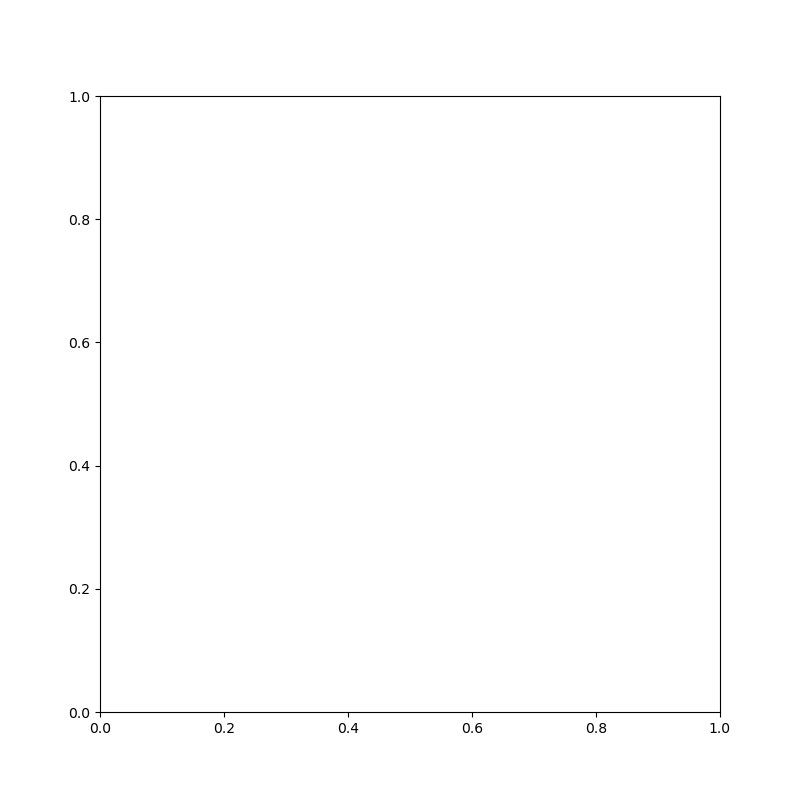

In [3]:
%matplotlib widget
import matplotlib as mpl
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap, Normalize

fig, ax1 = plt.subplots(figsize=(8, 8))
def plot_outputs(N=25, P=30, R=250, g=4, a=0.07,
                     h=1, rI=144, rE=144, rY=1500):
    try:
        iss = g/52*R/(rI/52)
        ess = (g/52-h/52-a/52*N)/(a/52)
    except:
        iss = 0
        ess= 0

    ax1.plot(iss,ess,'g*', markersize=12)
    # Handle initial domain plot
    color_vals_init_domain = np.zeros([P*10+1,P*10+1]) # Color values for initial domain plot
    for e in range(0, P*10+1):
        for i in range(0, P*10+1):
            calculator = StabilityCalculator(i/10, e/10, N, P, R, g/52, a/52, h/52, rI/52, rE/52, rY/52)
            init_domain = calculator.determine_domain()
            c_value_dom = None
            if init_domain == 'mentee':
                c_value_dom = 0
            elif init_domain == 'mentor':
                c_value_dom = 1
            elif init_domain == 'yfr':
                c_value_dom = 2
            else:
                c_value_dom = 3
            color_vals_init_domain[e,i] = c_value_dom
    values = [0,1,2,3]
    cmp = ListedColormap(['limegreen', 'lightslategray', 'chocolate', 'royalblue'])
    im = ax1.imshow(color_vals_init_domain, origin='lower', cmap=cmp, vmin=0, vmax=3, interpolation='none', alpha=0.2, extent=(0,P+0.5,0,P+0.5))
    colors = [ im.cmap(value) for value in values]
    star = mlines.Line2D([], [], color='green', marker='*', linestyle='None',
                      markersize=12, label='Steady State')
    patches = [ mpatches.Patch(color=colors[0], label="Mentee-Limited"),
            mpatches.Patch(color=colors[1], label="Mentor-Limited"),
            mpatches.Patch(color=colors[2], label="Resource-Limited"),
            mpatches.Patch(color=colors[3], label="Position-Limited"),
              star]
    ax1.legend(handles=patches, loc='upper right')

    # Plot vector field in background
    x,y = np.meshgrid(np.linspace(0,P+1,P+1),np.linspace(0,P+1,P+1)) 
    u = np.zeros(x.shape) # dI/dt for vector field
    v = np.zeros(y.shape) # dE/dt for vector field
    for e in range(0, P+1):
        for i in range(0, P+1):
            # Update vector field
            x_val, y_val = get_vector_coordinates(i, e, N, P, R, g/52, a/52, h/52, rI/52, rE/52, rY/52)
            u[e,i] = x_val
            v[e,i] = y_val
    r = np.power(np.add(np.power(u,2),np.power(v,2)),0.5) # Normalize vectors
    ax1.quiver(x,y,u/r,v/r, color='silver')
    ax1.axis([0, P+0.5, 0, P+0.5])
    

# Function to handle mouse click event
init_text = None
def on_click(event):
    global curr_traj
    global init_text
    if event.button == 1:  # Check if left mouse button is clicked
        for elem in curr_traj:
            elem.remove()
        curr_traj=[]
        # Get clicked coordinates
        x_click = round(event.xdata)
        y_click = round(event.ydata)

        if init_text:
            init_text.remove()
        init_text = ax1.text(0.9,0.04,'$I_0=$'+str(x_click)+'$, E_0=$'+str(y_click),
            horizontalalignment='center',
            verticalalignment='center',
            transform = ax1.transAxes,
            bbox=dict(facecolor='white', alpha=0.7))
        # Plot something on top of the quiver plot at clicked coordinates
        #ax1.plot(x_click, y_click, 'ro')  # Example: plotting a red dot
        plot_tracker(I=x_click, E=y_click)
        # Refresh the plot
        plt.draw()

curr_traj=[]
def plot_tracker(I=0, E=0,N=25, P=30, R=250, g=4, a=0.07,
                     h=1, rI=144, rE=144, rY=1500):
    global curr_traj
    calculator = StabilityCalculator(I, E, N, P, R, g/52, a/52, h/52, rI/52, rE/52, rY/52)
    _, status, _, tracking_info = calculator.run()
    I_points = tracking_info['I']
    E_points = tracking_info['E']
    domains = tracking_info['domains']
    xover_points = tracking_info['xover_points']

    try:
        iss = g/52*R/(rI/52)
        ess = (g/52-h/52-a/52*N)/(a/52)
    except:
        iss = 0
        ess= 0

    plotted, = ax1.plot(I_points[0],E_points[0],'ko', markersize=5)
    curr_traj.append(plotted)

    # Plot the points and arrow
    for x in range(len(I_points)-1):
        t=np.linspace(0,xover_points[x+1]-xover_points[x],100)
        # Arrow starts 1 week in past
        t_arrow_start = xover_points[x+1]-xover_points[x]-1
        if domains[x] == 'mentee':
            if domains[x+1] == 'Steady State':
                # System will continue to reach steady state, arbitrary values 
                t=np.linspace(0, 10000, 1000000)
                t_arrow_start = 5000
            x1=calculator.I_mentee_lim(E_points[x], I_points[x], t)
            y1=calculator.E_mentee_lim(E_points[x],I_points[x], t)
            I_arrow_start = calculator.I_mentee_lim(E_points[x], I_points[x], t_arrow_start)
            E_arrow_start = calculator.E_mentee_lim(E_points[x],I_points[x], t_arrow_start)
        elif domains[x] == 'mentor':
            x1=calculator.I_mentor_lim(E_points[x], I_points[x], t)
            y1=calculator.E_mentor_lim(E_points[x],I_points[x], t)
            I_arrow_start = calculator.I_mentor_lim(E_points[x], I_points[x], t_arrow_start)
            E_arrow_start = calculator.E_mentor_lim(E_points[x],I_points[x], t_arrow_start)
        elif domains[x] == 'yfr':
            x1=calculator.I_yfr_lim(I_points[x], t)
            y1=calculator.E_yfr_lim(E_points[x], t)
            I_arrow_start = calculator.I_yfr_lim(I_points[x], t_arrow_start)
            E_arrow_start = calculator.E_yfr_lim(E_points[x], t_arrow_start)
        else:
            x1=calculator.I_position_lim(I_points[x], t)
            y1=calculator.E_position_lim(E_points[x],I_points[x], t)
            I_arrow_start = calculator.I_position_lim(I_points[x], t_arrow_start)
            E_arrow_start = calculator.E_position_lim(E_points[x],I_points[x], t_arrow_start)
        if x == 0:
            plotted, = ax1.plot(x1,y1, color='black', label='Analytic Trajectory')
            curr_traj.append(plotted)
        else:
            plotted, = ax1.plot(x1,y1, color='black')
            curr_traj.append(plotted)
        # Only plot the last arrow
        if x == (len(I_points)-2):
            plotted = ax1.arrow(I_arrow_start, E_arrow_start, I_points[x+1]-I_arrow_start, E_points[x+1]-E_arrow_start, lw=0, length_includes_head=True, head_width=0.5, color='black')
            curr_traj.append(plotted)

    # Generate the table
    col_labels = ['Time (years)', 'Domain']
    table_vals = []
    cell_colors = []
    for i in range(len(xover_points)):
        if domains[i] == 'mentee':
            table_vals.append([round(xover_points[i]/52,2),'Mentee-Limited'])
            cell_colors.append(['lightgreen','lightgreen'])
        elif domains[i] == 'mentor':
            cell_colors.append(['lightslategray','lightslategray'])
            table_vals.append([round(xover_points[i]/52,2),'Mentor-Limited'])
        elif domains[i] == 'yfr':
            cell_colors.append(['chocolate','chocolate'])
            table_vals.append([round(xover_points[i]/52,2),'Resource-Limited'])
        elif domains[i] == 'position':
            cell_colors.append(['royalblue','royalblue'])
            table_vals.append([round(xover_points[i]/52,2),'Position-Limited'])
        elif domains[i] == 'Steady State':
            table_vals.append([round(xover_points[i]/52,2),'Steady State'])
            cell_colors.append(['lightgreen','lightgreen'])
        elif domains[i] == 'Mentor-Limited Crash':
            table_vals.append([round(xover_points[i]/52,2),'Crash'])
            cell_colors.append(['lightslategray','lightslategray'])
        else:
            cell_colors.append(['royalblue','royalblue'])
            table_vals.append([round(xover_points[i]/52,2),'Crash'])            

    plotted = ax1.table(cellText=table_vals,
                colLabels=col_labels,
                colWidths=[0.2,0.2],
                loc='upper left',
                cellLoc='left',
                cellColours = cell_colors,
                zorder=10)
    curr_traj.append(plotted)

    #ax1.set_title('Trajectory of System')
    ax1.set_xlabel('I')
    ax1.set_ylabel('E')
    ax1.axis([0, P+0.5, 0, P+0.5])
    ax1.plot(iss,ess,'g*', markersize=12)

# Connect the mouse click event to the function
fig.canvas.mpl_connect('button_press_event', on_click)

# Enable widget use
widgets.interact_manual(plot_outputs, I=widgets.IntSlider(value=18, min=0, max=100),
               E=widgets.IntSlider(value=8, min=0, max=100),
               P=widgets.IntSlider(value=30, min=0, max=100),
               N=widgets.IntSlider(value=25, min=0, max=100),
               R=widgets.IntSlider(value=250, min=0, max=1000),
               g=widgets.IntSlider(value=4, min=0, max=100),
               a=widgets.FloatSlider(value=0.07, min=0, max=1, step=0.01),
               h=widgets.IntSlider(value=1, min=0, max=100),
               rI=widgets.IntSlider(value=144, min=0, max=1000),
               rE=widgets.IntSlider(value=144, min=0, max=1000),
               rY=widgets.IntSlider(value=1500, min=0, max=100000))
pass

***

### Continuous Areas of System Sustainability

The following will output a plot similar to first plot of the above instance, but will consider fractional people to construct of more representative graph. This plot will take a considerable amount of time to generate (possibly upwards of 5-10 minutes), but a progress bar will appear to ease your frustration :).

In [5]:
%matplotlib inline
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap, Normalize
from IPython.display import display


def plot_outputs(N=25, P=30, R=250, g=4, a=0.07,
                     h=1, rI=144, rE=144, rY=10000):
    """Function used to plot the continuous system sustainability plot.

    Args:
        See StabilityCalculator args.
    """

    progress_bar = widgets.IntProgress(min=0, max=P*10+1, description='Loading:', style={'bar_color': 'green'},)
    display(progress_bar)

    plt.rcParams["figure.figsize"] = (10,10)

    frac_color_vals = np.zeros([P*10+1, P*10+1])

    for e in range(P*10+1):
        progress_bar.value += 1
        for i in range(P*10+1):
            calculator = StabilityCalculator(i/10, e/10, N, P, R, g/52, a/52, h/52, rI/52, rE/52, rY/52)
            _, status, _, _ = calculator.run()

            # Update colors for end state and vector field
            c_value = None
            if status == 'PASS':
                c_value = 0
            elif status == 'FAIL_MENTOR':
                c_value = 1
            else:
                c_value = 2
            frac_color_vals[e,i] = c_value
                
    try:
        iss = g*R/rI
        ess = (g-h-a*N)/a
    except:
        iss = 0
        ess= 0
    # Plot steady-state
    plt.plot(iss*10,ess*10,'k*', markersize=10) 
    # Star for marker on legend
    star = mlines.Line2D([], [], color='black', marker='*', linestyle='None',
                          markersize=10, label='Steady State')
    # Handle end state subplot
    values = [0,1,2]
    cmp = ListedColormap(['limegreen', 'mediumpurple', 'crimson'])
    im = plt.imshow(frac_color_vals, origin='lower', cmap=cmp, vmin=0, vmax=2, interpolation='none', extent=(0,P,0,P))
    colors = [im.cmap(value) for value in values]
    dashed_line = plt.axline((0,P*10), slope=-1, linestyle='dashed', label='E+I=P', c='black')
    patches = [ mpatches.Patch(color=colors[0], label="Success"),
            mpatches.Patch(color=colors[1], label="Mentor-Limited Crash"),
            mpatches.Patch(color=colors[2], label="Position-Limited Crash"),
            star,
            dashed_line]
    plt.legend(handles=patches, loc='upper right')
    '''
    plt.xticks(np.arange(-.5, P*10+0.5, 10), minor=True)
    plt.yticks(np.arange(-.5, P*10+0.5, 10), minor=True)
    plt.xticks(np.arange(0, P*10+20, 20), labels=np.arange(0, P+2, 2))
    plt.yticks(np.arange(0, P*10+20, 20), labels=np.arange(0, P+2, 2))
    '''
    #plt.grid(which='minor')
    plt.title('Stability Based on Initial Experienced and Inexperienced Pilots')
    plt.xlabel('I0')
    plt.ylabel('E0')


# Enable to slider interaction
widgets.interact_manual(plot_outputs, N=widgets.IntSlider(value=25, min=0, max=100),
               P=widgets.IntSlider(value=30, min=0, max=100),
               R=widgets.IntSlider(value=250, min=0, max=1000),
               g=widgets.IntSlider(value=4, min=0, max=100),
               a=widgets.FloatSlider(value=0.07, min=0, max=1, step=0.01),
               h=widgets.IntSlider(value=1, min=0, max=100),
               rI=widgets.IntSlider(value=144, min=0, max=1000),
               rE=widgets.IntSlider(value=144, min=0, max=1000),
               rY=widgets.IntSlider(value=10000, min=0, max=10000))
pass

interactive(children=(IntSlider(value=25, description='N'), IntSlider(value=30, description='P'), IntSlider(va…

***

### Stability Based on Initial Experienced Pilots and Attrition Rate

This plots the final sustainability of the system with varying values of E and a.

In [24]:
%matplotlib inline
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap


def plot_outputs(I=10, N=25, P=30, R=250, g=4,
                     h=1, rI=144, rE=144, rY=10000):
    """Plots E vs a.

    Args:
        See StabilityCalculator args.
    """
    plt.rcParams["figure.figsize"] = (10,10)

    color_vals = np.zeros([P-I+1,31], dtype=int)
    for a in range(0,31):
        for E in range(0, P-I+1):
            predictor = StabilityCalculator(I, E, N, P, R, g/52, a/100/52, h/52, rI/52, rE/52, rY/52)
            _, status, _, _ = predictor.run()
            c_value = None
            c_value = None
            if status == 'PASS':
                c_value = 0
            elif status == 'FAIL_MENTOR':
                c_value = 1
            else:
                c_value = 2
            color_vals[E,a] = c_value
    values = [0,1,2]
    cmp = ListedColormap(['limegreen', 'mediumpurple', 'crimson'])
    im = plt.imshow(color_vals, origin='lower', cmap=cmp, vmin=0, vmax=2)
    colors = [im.cmap(value) for value in values]
    patches = [ mpatches.Patch(color=colors[0], label="Success"),
            mpatches.Patch(color=colors[1], label="Mentor-Limited Crash"),
            mpatches.Patch(color=colors[2], label="Position-Limited Crash")]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('Stability Based on Initial Experienced Pilots and Attrition Rate')
    plt.xlabel('a')
    plt.ylabel('E0')
    plt.xticks(range(0,31,5), labels=[x/100 for x in range(0,31, 5)])
    plt.xticks(np.arange(-.5, P+0.5, 1), minor=True)
    plt.yticks(range(0,P-I+1,5))
    plt.yticks(np.arange(-.5, P-I+0.5, 1), minor=True)
    plt.grid(which='minor')

widgets.interact_manual(plot_outputs, N=widgets.IntSlider(value=25, min=0, max=100),
               P=widgets.IntSlider(value=30, min=0, max=100),
               R=widgets.IntSlider(value=250, min=0, max=1000),
               g=widgets.IntSlider(value=4, min=0, max=100),
               h=widgets.IntSlider(value=1, min=0, max=100),
               rI=widgets.IntSlider(value=144, min=0, max=1000),
               rE=widgets.IntSlider(value=144, min=0, max=1000),
               rY=widgets.IntSlider(value=10000, min=0, max=100000),
               I=widgets.IntSlider(value=10, min=0, max=100))
pass

interactive(children=(IntSlider(value=10, description='I'), IntSlider(value=25, description='N'), IntSlider(va…

***

### Stability Based on Initial Inexperienced Pilots and Attrition Rate

This plots the final sustainability of the system with varying values of I and a.

In [8]:
%matplotlib inline
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

def plot_predictions(E=10, N=25, P=30, R=250, g=4,
                     h=1, rI=144, rE=144, rY=10000):
    """Plots I vs a.

    Args:
        See StabilityCalculator args.
    """
    
    plt.rcParams["figure.figsize"] = (10,10)

    color_vals = np.zeros([P-E+1,31], dtype=int)
    for a in range(0,31):
        for I in range(0, P-E+1):
            predictor = StabilityCalculator(I, E, N, P, R, g/52, a/100/52, h/52, rI/52, rE/52, rY/52)
            _, status, _, _ = predictor.run()
            c_value = None
            if status == 'PASS':
                c_value = 0
            elif status == 'FAIL_MENTOR':
                c_value = 1
            else:
                c_value = 2
            color_vals[I,a] = c_value

    values = [0,1,2]
    cmp = ListedColormap(['limegreen', 'mediumpurple','crimson'])
    im = plt.imshow(color_vals, origin='lower', cmap=cmp, vmin=0, vmax=2)
    colors = [im.cmap(value) for value in values]
    patches = [ mpatches.Patch(color=colors[0], label="Success"),
            mpatches.Patch(color=colors[1], label="Mentor-Limited Crash"),
            mpatches.Patch(color=colors[2], label="Position-Limited Crash")]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('Stability Based on Initial Inexperienced Pilots and Attrition Rate')
    plt.xlabel('a')
    plt.ylabel('I0')
    plt.xticks(range(0,31,5), labels=[x/100 for x in range(0,31, 5)])
    plt.xticks(np.arange(-.5, P+0.5, 1), minor=True)
    plt.yticks(range(0,P-E+1,5))
    plt.yticks(np.arange(-.5, P-E+0.5, 1), minor=True)
    plt.grid(which='minor')

widgets.interact_manual(plot_predictions, N=widgets.IntSlider(value=25, min=0, max=100),
               P=widgets.IntSlider(value=30, min=0, max=100),
               R=widgets.IntSlider(value=250, min=0, max=1000),
               g=widgets.IntSlider(value=4, min=0, max=100),
               h=widgets.IntSlider(value=1, min=0, max=100),
               rI=widgets.IntSlider(value=144, min=0, max=1000),
               rE=widgets.IntSlider(value=144, min=0, max=1000),
               rY=widgets.IntSlider(value=10000, min=0, max=100000),
               E=widgets.IntSlider(value=10, min=0, max=100))
pass

interactive(children=(IntSlider(value=10, description='E'), IntSlider(value=25, description='N'), IntSlider(va…

***

### Stability of the System Based on Initial Experienced and Non-Operational Positions

This plots the final sustainability of the system with varying values of E and N.

In [9]:
%matplotlib inline
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

def plot_predictions(I=10, a=0.07, P=30, R=250, g=4,
                     h=1, rI=144, rE=144, rY=10000):
    """Plots E vs N.

    Args:
        See StabilityCalculator args.
    """
    
    plt.rcParams["figure.figsize"] = (10,10)

    color_vals = np.zeros([P-I+1,P+1], dtype=int)
    for N in range(0,P+1):
        for E in range(0, P-I+1):
            predictor = StabilityCalculator(I, E, N, P, R, g/52, a/52, h/52, rI/52, rE/52, rY/52)
            _, status, _, _ = predictor.run()
            c_value = None
            if status == 'PASS':
                c_value = 0
            elif status == 'FAIL_MENTOR':
                c_value = 1
            else:
                c_value = 2
            color_vals[E,N] = c_value

    values = [0,1,2]
    cmp = ListedColormap(['limegreen', 'mediumpurple','crimson'])
    im = plt.imshow(color_vals, origin='lower', cmap=cmp, vmin=0, vmax=2)
    colors = [im.cmap(value) for value in values]
    patches = [ mpatches.Patch(color=colors[0], label="Success"),
            mpatches.Patch(color=colors[1], label="Mentor-Limited Crash"),
            mpatches.Patch(color=colors[2], label="Position-Limited Crash")]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('Stability Based on Initial Experienced Pilots and Non-Operational Positions')
    plt.xlabel('N')
    plt.ylabel('E0')
    plt.xticks(range(0,P+1,5))
    plt.xticks(np.arange(-.5, P+0.5, 1), minor=True)
    plt.yticks(range(0,P-I+1,5))
    plt.yticks(np.arange(-.5, P-I+0.5, 1), minor=True)
    plt.grid(which='minor')

widgets.interact_manual(plot_predictions, a=widgets.FloatSlider(value=0.07, min=0, max=1, step=0.01),
               P=widgets.IntSlider(value=30, min=0, max=100),
               R=widgets.IntSlider(value=250, min=0, max=1000),
               g=widgets.IntSlider(value=4, min=0, max=100),
               h=widgets.IntSlider(value=1, min=0, max=100),
               rI=widgets.IntSlider(value=144, min=0, max=1000),
               rE=widgets.IntSlider(value=144, min=0, max=1000),
               rY=widgets.IntSlider(value=10000, min=0, max=100000),
               I=widgets.IntSlider(value=10, min=0, max=10))
pass

interactive(children=(IntSlider(value=10, description='I', max=10), FloatSlider(value=0.07, description='a', m…

***

### Stability of the System Based on Initial Inexperienced and Non-Operational Positions

This plots the final sustainability of the system with varying values of I and N.

In [2]:
%matplotlib inline
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

def plot_predictions(E=10, a=0.07, P=30, R=250, g=4,
                     h=1, rI=144, rE=144, rY=10000):
    """Plots I vs a.

    Args:
        See StabilityCalculator args.
    """
    
    plt.rcParams["figure.figsize"] = (10,10)
    color_vals = np.zeros([P-E+1,P+1], dtype=int)
    for N in range(0,P+1):
        for I in range(0, P-E+1):
            predictor = StabilityCalculator(I, E, N, P, R, g/52, a/52, h/52, rI/52, rE/52, rY/52)
            _, status, _, _ = predictor.run()
            c_value = None
            if status == 'PASS':
                c_value = 0
            elif status == 'FAIL_MENTOR':
                c_value = 1
            else:
                c_value = 2
            color_vals[I,N] = c_value

    values = [0,1,2]
    cmp = ListedColormap(['limegreen', 'mediumpurple', 'crimson'])
    im = plt.imshow(color_vals, origin='lower', cmap=cmp, vmin=0, vmax=2)
    colors = [im.cmap(value) for value in values]
    patches = [ mpatches.Patch(color=colors[0], label="Success"),
            mpatches.Patch(color=colors[1], label="Mentor-Limited Crash"),
            mpatches.Patch(color=colors[2], label="Position-Limited Crash")]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('Stability Based on Initial Inexperienced Pilots and Non-Operational Positions')
    plt.xlabel('N')
    plt.ylabel('I0')
    plt.xticks(range(0,P+1,5))
    plt.xticks(np.arange(-.5, P+0.5, 1), minor=True)
    plt.yticks(range(0,P-E+1,5))
    plt.yticks(np.arange(-.5, P-E+0.5, 1), minor=True)
    plt.grid(which='minor')

widgets.interact_manual(plot_predictions, a=widgets.FloatSlider(value=0.07, min=0, max=1, step=0.01),
               P=widgets.IntSlider(value=30, min=0, max=100),
               R=widgets.IntSlider(value=250, min=0, max=1000),
               g=widgets.IntSlider(value=4, min=0, max=100),
               h=widgets.IntSlider(value=1, min=0, max=100),
               rI=widgets.IntSlider(value=144, min=0, max=1000),
               rE=widgets.IntSlider(value=144, min=0, max=1000),
               rY=widgets.IntSlider(value=10000, min=0, max=100000),
               e=widgets.IntSlider(value=10, min=0, max=100))
pass

interactive(children=(IntSlider(value=10, description='E', max=30, min=-10), FloatSlider(value=0.07, descripti…

***

### Stability of the System Depending on Attrition Rate and Non-Operational Positions

This plots the final sustainability of the system with varying values of N and a.

In [ ]:
%matplotlib inline
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

def plot_predictions(E=10, I=10, P=30, R=250, g=4,
                     h=1, rI=144, rE=144, rY=10000):
    """Plots a vs N.

    Args:
        See StabilityCalculator args.
    """
    
    plt.rcParams["figure.figsize"] = (10,10)

    color_vals = np.zeros([31,P+1], dtype=int)
    for N in range(0,P+1):
        for a in range(0, 31):
            predictor = StabilityCalculator(I, E, N, P, R, g/52, a/100/52, h/52, rI/52, rE/52, rY/52)
            _, status, _, _ = predictor.run()
            c_value = None
            if status == 'PASS':
                c_value = 0
            elif status == 'FAIL_MENTOR':
                c_value = 1
            else:
                c_value = 2
            color_vals[a,N] = c_value

    values = [0,1,2]
    cmp = ListedColormap(['limegreen', 'mediumpurple', 'crimson'])
    im = plt.imshow(color_vals, origin='lower', cmap=cmp, vmin=0, vmax=2)
    colors = [im.cmap(value) for value in values]
    patches = [ mpatches.Patch(color=colors[0], label="Success"),
            mpatches.Patch(color=colors[1], label="Mentor-Limited Crash"),
            mpatches.Patch(color=colors[2], label="Position-Limited Crash")]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('Stability Based on Non-Operational Positions and Attrition Rate')
    plt.xlabel('N')
    plt.ylabel('a')
    plt.xticks(range(0,P+1,5))
    plt.xticks(np.arange(-.5, P+0.5, 1), minor=True)
    plt.yticks(range(0,31,5), labels=[x/100 for x in range(0,31,5)])
    plt.yticks(np.arange(-.5, 31, 1), minor=True)
    plt.grid(which='minor')
  
widgets.interact_manual(plot_predictions, I=widgets.IntSlider(value=10, min=0, max=100),
               E=widgets.IntSlider(value=10, min=0, max=100),
               P=widgets.IntSlider(value=30, min=0, max=100),
               R=widgets.IntSlider(value=250, min=0, max=1000),
               g=widgets.IntSlider(value=4, min=0, max=100),
               h=widgets.IntSlider(value=1, min=0, max=100),
               rI=widgets.IntSlider(value=144, min=0, max=1000),
               rE=widgets.IntSlider(value=144, min=0, max=1000),
               rY=widgets.IntSlider(value=10000, min=0, max=100000))
pass

***

### (PAPER) Vector Field w/ steady-state inset

In [30]:
%matplotlib inline
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.ticker import FormatStrFormatter


def plot_outputs(N=25, P=30, R=250, g=4, a=0.07,
                     h=1, rI=144, rE=144, rY=10000):
    """Function used to plot the main outputs of the analytic tool.

    Args:
        See StabilityCalculator args.
    """
    fig, ax1 = plt.subplots(figsize=(10,10))

    x,y = np.meshgrid(np.linspace(0,P+1,P+1),np.linspace(0,P+1,P+1)) 
    u = np.zeros(x.shape) # dI/dt for vector field
    v = np.zeros(y.shape) # dE/dt for vector field
    times = np.zeros([P+1,P+1]) # Times in danger
    color_vals = np.zeros([P+1,P+1]) # Color values for end state and vector field
    color_vals_2 = np.zeros([P+1,P+1]) # Color values for transient PML violation
    color_vals_init_domain = np.zeros([P+1,P+1]) # Color values for initial domain plot
    
    for e in range(0, P+1):
        for i in range(0, P+1):
            # Update vector field
            x_val, y_val = get_vector_coordinates(i, e, N, P, R, g/52, a/52, h/52, rI/52, rE/52, rY/52)
            u[e,i] = x_val
            v[e,i] = y_val
            
            calculator = StabilityCalculator(i, e, N, P, R, g/52, a/52, h/52, rI/52, rE/52, rY/52)
            init_domain = calculator.determine_domain()
            time_in_danger, status, exceeds_P, _ = calculator.run()

            times[e,i] = time_in_danger

            # Update colors for end state and vector field
            c_value = None
            if status == 'PASS':
                c_value = 0
            elif status == 'FAIL_MENTOR':
                c_value = 1
            else:
                c_value = 2
            color_vals[e,i] = c_value

            # Update colors for PML violation
            c_value_2 = None
            if status != 'PASS':
                c_value_2 = 3
            else:
                if not exceeds_P:
                    c_value_2 = 1
                else:
                    c_value_2 = 2
            color_vals_2[e,i] = c_value_2

            # Update colors for init domain plot
            c_value_dom = None
            if init_domain == 'mentee':
                c_value_dom = 0
            elif init_domain == 'mentor':
                c_value_dom = 1
            elif init_domain == 'yfr':
                c_value_dom = 2
            else:
                c_value_dom = 3
            color_vals_init_domain[e,i] = c_value_dom
                
    try:
        iss = g*R/rI
        ess = (g-h-a*N)/a
    except:
        iss = 0
        ess= 0

    # Plot steady-state
    ax1.plot(iss,ess,'k*', markersize=15) 
    # Star for marker on legend
    star = mlines.Line2D([], [], color='black', marker='*', linestyle='None',
                          markersize=10, label='Steady State')
    # Handle end state subplot
    values = [0,1,2]
    cmp = ListedColormap(['limegreen', 'mediumpurple', 'crimson'])
    colors = ['limegreen', 'mediumpurple', 'crimson']

    # Handle vector field subplot
    patches = [ mpatches.Patch(color=colors[0], label="Success"),
            mpatches.Patch(color=colors[1], label="Mentor-Limited Crash"),
            mpatches.Patch(color=colors[2], label="Position-Limited Crash"),
            star]
    ax1.legend(handles=patches, loc='upper right')
    r = np.power(np.add(np.power(u,2),np.power(v,2)),0.5) # Normalize vectors
    ax1.quiver(x,y,u/r,v/r, color_vals, cmap=cmp, norm=Normalize(vmin=0, vmax=2))
    #ax1.set_title('Change in Pilot Populations')
    ax1.set_xlabel('I', fontsize=15)
    #ax1.set_ylabel('E', fontsize=15)
    ax1.tick_params(axis='x', labelsize=15)
    ax1.set_ylim([0,P])
    ax1.set_xlim([0,P])
    ax1.set_yticks([])

    # Handle Inset
    x1, x2, y1, y2 = 6.94, 6.95, 17.85, 17.86
    #axins = ax1.inset_axes(
    #[0.35, 0.65, 0.25, 0.25])
    axins = ax1.inset_axes([10,21,8,8], transform=ax1.transData)

    poss_e_vals = [x/1000 for x in range(17850,17861)]
    poss_i_vals = [x/1000 for x in range(6940,6951)]
    x,y=np.meshgrid(poss_i_vals,poss_e_vals)  
    u = np.zeros(x.shape) # dI/dt for vector field
    v = np.zeros(y.shape) # dE/dt for vector field
    for e in poss_e_vals:
        for i in poss_i_vals:
            # Update vector field
            x_val, y_val = get_vector_coordinates(i, e, 25, 30, 250, 4/52, 0.07/52, 1/52, 144/52, 144/52, 10000/52)
            e_cord = int(e*1000-17850)
            i_cord = int(i*1000-6940)
            u[e_cord,i_cord] = x_val
            v[e_cord,i_cord] = y_val
    r = np.power(np.add(np.power(u,2),np.power(v,2)),0.5) # Normalize vectors
    axins.quiver(x,y,u/r,v/r, color='grey')
    #plt.xticks(ticks=range(11),labels=[round(6.94+0.001*i,3) for i in range(11)])
    #plt.yticks(ticks=range(11),labels=[round(17.85+0.001*i,3) for i in range(11)])
    try:
        iss = 4/52*250/(144/52)
        ess = (4/52-1/52-0.07/52*25)/(0.07/52)
    except:
        iss = 0
        ess= 0
    #x_val, y_val = get_vector_coordinates(6.944, 17.857, 25, 30, 250, 4/52, 0.07/52, 1/52, 144/52, 144/52, 10000/52)
    #print(x_val,y_val)
    axins.plot(iss,ess,'k*', markersize=10)
    axins.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    #axins.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    axins.tick_params(axis='both', which='major', labelsize=15)
    axins.set_xticks([6.94,6.945, 6.95])
    ax1.add_patch(mpatches.Rectangle((6,17),2,2, fill=False, lw=0.5))
    ax1.add_patch(mpatches.ConnectionPatch((6,19), (10,29), 'data', lw=0.5))
    ax1.add_patch(mpatches.ConnectionPatch((8,17), (18,21), 'data', lw=0.5))

# Enable to slider interaction
widgets.interact_manual(plot_outputs, N=widgets.IntSlider(value=25, min=0, max=100),
               P=widgets.IntSlider(value=30, min=0, max=100),
               R=widgets.IntSlider(value=250, min=0, max=1000),
               g=widgets.IntSlider(value=4, min=0, max=100),
               a=widgets.FloatSlider(value=0.07, min=0, max=1, step=0.01),
               h=widgets.IntSlider(value=1, min=0, max=100),
               rI=widgets.IntSlider(value=144, min=0, max=1000),
               rE=widgets.IntSlider(value=144, min=0, max=1000),
               rY=widgets.IntSlider(value=1500, min=0, max=10000))
pass


interactive(children=(IntSlider(value=25, description='N'), IntSlider(value=30, description='P'), IntSlider(va…

***

### (PAPER) Population Level Tracker with dt

In [21]:
%matplotlib inline
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from matplotlib.ticker import MaxNLocator
from IPython.display import display

def steady_state_time(Iss, I, Ess, E, N, R, g, a, h, rI, last_t):
    """Returns the time at which the system will reach steady state.

    In theory, this never happens. However, for in practice, we will consider
    that the system reaches steady state when |Iss-I| < 1 and |Ess-E| < 1.

    Args:
        Iss (float): The mentee population steady-state value.
        Ess (float): The mentor population steady-state value.
        last_t (float): The time of the last crossover point.
        Others: See StabilityCalculator args.
    """
    k1 = I-Iss
    k2=E+(rI/(rI-a*R))*k1-(g-h-a*N)/a
    t1 = -1
    t2 = -1
    
    if abs(Iss-I)<1:
        t1 = 0
    elif Iss > I:
        t1 = -R*log(-0.05*Iss/k1)/rI
    else:
        t1 = -R*log(0.05*Iss/k1)/rI
        
    if abs(Ess-E)<1:
        t2 = 0
    elif Ess > E:
        func = lambda t: Ess-(-rI/(rI-a*R)*k1*np.exp(-rI*t/R)+k2*np.exp(-a*t)+\
                (g-h-a*N)/a)-0.05*Ess
        t2 = root_scalar(func, bracket=[0, get_threshold(func, last_t)]).root
    else:
        func = lambda t: (-rI/(rI-a*R)*k1*np.exp(-rI*t/R)+k2*np.exp(-a*t)+\
                (g-h-a*N)/a)-0.05*Ess-Ess
        t2 = root_scalar(func, bracket=[0, get_threshold(func, last_t)]).root
    
    return max(t1,t2)

def get_threshold(func, last_t):
        """Returns an upper bracket for use in steady_state_time().

        Calculate when the function will change signs. In our case,
        it is used to find when Ess-E-1 will change signs.
        """
        i = last_t
        done = False
        # Checking for sign change within next 40 years
        while i < last_t+10000 and done == False:
            if func(i) < 0:
                done = True
            i+=1
        return i
    

def plot_outputs(I=10, E=10, P=30, N=25, R=250, g=4,
                     a=0.07, h=1, rI=144, rE=144, rY=10000):
    """Plots the trajectory of the system.

    Args:
        See StabilityCalculator args.
    """
    
    plt.rcParams["figure.figsize"] = (8,8)
    fig, ax1 = plt.subplots()
    fig.set_tight_layout(False)

    # Handle initial domain plot
    color_vals_init_domain = np.zeros([P*10+1,P*10+1]) # Color values for initial domain plot
    for e in range(0, P*10+1):
        for i in range(0, P*10+1):
            calculator = StabilityCalculator(i/10, e/10, N, P, R, g/52, a/52, h/52, rI/52, rE/52, rY/52)
            init_domain = calculator.determine_domain()
            c_value_dom = None
            if init_domain == 'mentee':
                c_value_dom = 0
            elif init_domain == 'mentor':
                c_value_dom = 1
            elif init_domain == 'yfr':
                c_value_dom = 2
            else:
                c_value_dom = 3
            color_vals_init_domain[e,i] = c_value_dom
    values = [0,1,2,3]
    cmp = ListedColormap(['limegreen', 'lightslategray', 'chocolate', 'royalblue'])
    im = ax1.imshow(color_vals_init_domain, origin='lower', cmap=cmp, vmin=0, vmax=3, interpolation='none', alpha=0.2, extent=(0,P+0.5,0,P+0.5))
    colors = [ im.cmap(value) for value in values]
    patches = [ mpatches.Patch(color=colors[0], label="Mentee-Limited"),
            mpatches.Patch(color=colors[1], label="Mentor-Limited"),
            mpatches.Patch(color=colors[2], label="Resource-Limited"),
            mpatches.Patch(color=colors[3], label="Position-Limited")]
    ax1.legend(handles=patches, loc='upper right')

    # Plot vector field in background
    x,y = np.meshgrid(np.linspace(0,P+1,P+1),np.linspace(0,P+1,P+1)) 
    u = np.zeros(x.shape) # dI/dt for vector field
    v = np.zeros(y.shape) # dE/dt for vector field
    for e in range(0, P+1):
        for i in range(0, P+1):
            # Update vector field
            x_val, y_val = get_vector_coordinates(i, e, N, P, R, g/52, a/52, h/52, rI/52, rE/52, rY/52)
            u[e,i] = x_val
            v[e,i] = y_val
    r = np.power(np.add(np.power(u,2),np.power(v,2)),0.5) # Normalize vectors
    ax1.quiver(x,y,u/r,v/r, color='silver')

    calculator = StabilityCalculator(I, E, N, P, R, g/52, a/52, h/52, rI/52, rE/52, rY/52)
    _, status, _, tracking_info = calculator.run()
    I_points = tracking_info['I']
    E_points = tracking_info['E']
    domains = tracking_info['domains']
    xover_points = tracking_info['xover_points']

    try:
        iss = g/52*R/(rI/52)
        ess = (g/52-h/52-a/52*N)/(a/52)
    except:
        iss = 0
        ess= 0

    ax1.plot(I_points[0],E_points[0],'ko', markersize=5)

    # Plot the points and arrow
    for x in range(len(I_points)-1):
        t=np.linspace(0,xover_points[x+1]-xover_points[x],100)
        # Arrow starts 1 week in past
        t_arrow_start = xover_points[x+1]-xover_points[x]-1
        if domains[x] == 'mentee':
            if domains[x+1] == 'Steady State':
                # System will continue to reach steady state, arbitrary values 
                t=np.linspace(0, 10000, 1000000)
                t_arrow_start = 5000
            x1=calculator.I_mentee_lim(E_points[x], I_points[x], t)
            y1=calculator.E_mentee_lim(E_points[x],I_points[x], t)
            I_arrow_start = calculator.I_mentee_lim(E_points[x], I_points[x], t_arrow_start)
            E_arrow_start = calculator.E_mentee_lim(E_points[x],I_points[x], t_arrow_start)
        elif domains[x] == 'mentor':
            x1=calculator.I_mentor_lim(E_points[x], I_points[x], t)
            y1=calculator.E_mentor_lim(E_points[x],I_points[x], t)
            I_arrow_start = calculator.I_mentor_lim(E_points[x], I_points[x], t_arrow_start)
            E_arrow_start = calculator.E_mentor_lim(E_points[x],I_points[x], t_arrow_start)
        elif domains[x] == 'yfr':
            x1=calculator.I_yfr_lim(I_points[x], t)
            y1=calculator.E_yfr_lim(E_points[x], t)
            I_arrow_start = calculator.I_yfr_lim(I_points[x], t_arrow_start)
            E_arrow_start = calculator.E_yfr_lim(E_points[x], t_arrow_start)
        else:
            x1=calculator.I_position_lim(I_points[x], t)
            y1=calculator.E_position_lim(E_points[x],I_points[x], t)
            I_arrow_start = calculator.I_position_lim(I_points[x], t_arrow_start)
            E_arrow_start = calculator.E_position_lim(E_points[x],I_points[x], t_arrow_start)
        if x == 0:
            ax1.plot(x1,y1, color='black', label='Analytic Trajectory')
        else:
            ax1.plot(x1,y1, color='black')
        # Only plot the last arrow
        if x == (len(I_points)-2):
            ax1.arrow(I_arrow_start, E_arrow_start, I_points[x+1]-I_arrow_start, E_points[x+1]-E_arrow_start, lw=0, length_includes_head=True, head_width=0.5, color='black')

    # Generate the table
    col_labels = ['Time (years)', 'Domain']
    table_vals = []
    cell_colors = []
    for i in range(len(xover_points)):
        if domains[i] == 'mentee':
            table_vals.append([round(xover_points[i]/52,2),'Mentee-Limited'])
            cell_colors.append(['lightgreen','lightgreen'])
        elif domains[i] == 'mentor':
            cell_colors.append(['lightslategray','lightslategray'])
            table_vals.append([round(xover_points[i]/52,2),'Mentor-Limited'])
        elif domains[i] == 'yfr':
            cell_colors.append(['chocolate','chocolate'])
            table_vals.append([round(xover_points[i]/52,2),'Resource-Limited'])
        elif domains[i] == 'position':
            cell_colors.append(['royalblue','royalblue'])
            table_vals.append([round(xover_points[i]/52,2),'Position-Limited'])
        elif domains[i] == 'Steady State':
            table_vals.append([round(xover_points[i]/52,2),'Steady State'])
            cell_colors.append(['lightgreen','lightgreen'])
        elif domains[i] == 'Mentor-Limited Crash':
            table_vals.append([round(xover_points[i]/52,2),'Crash'])
            cell_colors.append(['lightslategray','lightslategray'])
        else:
            cell_colors.append(['royalblue','royalblue'])
            table_vals.append([round(xover_points[i]/52,2),'Crash'])            

    ax1.plot(iss,ess,'g*', markersize=12)
    ax1.table(cellText=table_vals,
                colLabels=col_labels,
                colWidths=[0.2,0.2],
                loc='upper left',
                cellLoc='left',
                cellColours = cell_colors,
                zorder=10)

    #ax1.set_title('Trajectory of System')
    ax1.set_xlabel('I')
    ax1.set_ylabel('E')
    ax1.axis([0, P+0.5, 0, P+0.5])

    # Inset
    left, bottom, width, height = [0.125, -0.15, 0.775, 0.2]
    ax2 = fig.add_axes([left, bottom, width, height])

    last_t = xover_points[-1]
    for x in range(len(I_points)-1):
        t_calc=np.linspace(0,xover_points[x+1]-xover_points[x],100)
        t_plot=np.linspace(xover_points[x],xover_points[x+1],100)
        if domains[x] == 'mentee':
            y1=calculator.I_mentee_lim(E_points[x], I_points[x], t_calc)
            y2=calculator.E_mentee_lim(E_points[x],I_points[x], t_calc)
        elif domains[x] == 'mentor':
            y1=calculator.I_mentor_lim(E_points[x], I_points[x], t_calc)
            y2=calculator.E_mentor_lim(E_points[x],I_points[x], t_calc)
        elif domains[x] == 'yfr':
            y1=calculator.I_yfr_lim(I_points[x], t_calc)
            y2=calculator.E_yfr_lim(E_points[x], t_calc)
        else:
            y1=calculator.I_position_lim(I_points[x], t_calc)
            y2=calculator.E_position_lim(E_points[x],I_points[x], t_calc)
        if x == 0:
            ax2.plot(t_plot,y1, color='black', label='I (Analytic)')
            ax2.plot(t_plot,y2,color='blue', label='E (Analytic)')
        else:
            ax2.plot(t_plot,y1, color='black')
            ax2.plot(t_plot,y2,color='blue')
    ax2.set_xticks(np.arange(0, last_t+52,104), labels=np.arange(0, last_t/52+1,2,dtype=int))
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Population')
    ax2.legend(loc='lower right')

    de_res = plot_dt(ax1, ax2, colors, I, E, P, N, R, g/52, a/52, h/52, rI/52, rE/52, rY/52)
    handles, labels = ax1.get_legend_handles_labels()
    handles = patches+handles
    ax1.legend(handles=handles, loc='upper right')

def u(I, E, P, R, rI, rE, rY):
    return min(rI/R*I, rE/R*E, rY/R, rE/R*(P-I))

def plot_dt(ax1,ax2, colors, I, E, P, N, R, g, a, h, rI, rE, rY):

    dt_vals = [3]
    for dt in dt_vals:
        
        t=[]
        x=[]
        y=[]
        curr_t=0
        #2184 = 42 years
        while(curr_t<2184):
            x.append(I)
            y.append(E)
            t.append(curr_t)
            I = I + (g-u(I,E,P,R,rI,rE,rY))*dt
            E = E + (u(I,E,P,R,rI,rE,rY)-h-a*E-a*N)*dt
            curr_t += dt
        ax2.plot(t,x, label='I (DE)', color='red')
        ax2.plot(t,y, label='E (DE)', color='green')
    de_res=ax1.plot(x,y,color='brown', label='DE Trajectory')
    ax2.legend(loc='upper right')
    return de_res

    

# Enable widget use
widgets.interact_manual(plot_outputs, I=widgets.IntSlider(value=22, min=0, max=100),
               E=widgets.IntSlider(value=6, min=0, max=100),
               P=widgets.IntSlider(value=30, min=0, max=100),
               N=widgets.IntSlider(value=25, min=0, max=100),
               R=widgets.IntSlider(value=250, min=0, max=1000),
               g=widgets.IntSlider(value=4, min=0, max=100),
               a=widgets.FloatSlider(value=0.07, min=0, max=1, step=0.01),
               h=widgets.IntSlider(value=1, min=0, max=100),
               rI=widgets.IntSlider(value=144, min=0, max=1000),
               rE=widgets.IntSlider(value=144, min=0, max=1000),
               rY=widgets.IntSlider(value=1500, min=0, max=100000))
pass

interactive(children=(IntSlider(value=22, description='I'), IntSlider(value=6, description='E'), IntSlider(val…

***

### (PAPER) MAE Plot

In [58]:
# MAE

%matplotlib inline
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from matplotlib.ticker import MaxNLocator
from IPython.display import display

def plot_outputs(I=10, E=10, P=30, N=25, R=250, g=4,
                     a=0.07, h=1, rI=144, rE=144, rY=10000):
    """Plots the trajectory of the system.

    Args:
        See StabilityCalculator args.
    """
    
    plt.rcParams["figure.figsize"] = (8,8)
    fig, ax1 = plt.subplots()

    calculator = StabilityCalculator(I, E, N, P, R, g/52, a/52, h/52, rI/52, rE/52, rY/52)
    _, status, _, tracking_info = calculator.run()
    I_points = tracking_info['I']
    E_points = tracking_info['E']
    domains = tracking_info['domains']
    xover_points = tracking_info['xover_points']
    
    #dt_vals = np.arange(0,5,0.0001)
    dt_vals=[1, 0.1, 0.01, 0.001, 0.0001]
    i_mae =[]
    e_mae =[]
    for dt in dt_vals:
        print('dt', dt)
        t, dt_i, dt_e = plot_dt(dt)
        i = []
        e = []
        #ax1.plot(t, dt_i, label='dti')
        #ax1.plot(t, dt_e, label='dte')

        
        for curr_t in t:
            k = 0
            for j in range(len(xover_points)-1):
                if curr_t>=xover_points[j] and curr_t<xover_points[j+1]:
                    k=j
                    break
            t_calc = curr_t - xover_points[j]
            if domains[k] == 'mentee':
                i.append(calculator.I_mentee_lim(E_points[k], I_points[k], t_calc))
                e.append(calculator.E_mentee_lim(E_points[k], I_points[k], t_calc))
            elif domains[k]=='mentor':
                i.append(calculator.I_mentor_lim(E_points[k], I_points[k], t_calc))
                e.append(calculator.E_mentor_lim(E_points[k], I_points[k], t_calc))
            elif domains[k]=='yfr':
                i.append(calculator.I_yfr_lim(I_points[k], t_calc))
                e.append(calculator.E_yfr_lim(E_points[k], t_calc))
            else:
                i.append(calculator.I_position_lim(I_points[k], t_calc))
                e.append(calculator.E_position_lim(E_points[k], I_points[k], t_calc))
                
        #ax1.plot(t,i, label='i')
        #ax1.plot(t,e, label='e')
        #ax1.plot(t, dt_i, label='dti')
        #ax1.plot(t, dt_e, label='dte')

        i_mae.append(get_mae(i, dt_i))
        e_mae.append(get_mae(e, dt_e))
    ax1.plot(dt_vals, i_mae, label='I', color='red')
    ax1.plot(dt_vals, e_mae, label='E', color='blue')
    ax1.set_xlabel('$\Delta t$')
    ax1.set_ylabel('MAE')
    ax1.legend()
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlim(1,0.0001)  # decreasing time
    ax1.set_ylim(bottom=0)

    

def u(I, E, P, R, rI, rE, rY):
    return min(rI/R*I, rE/R*E, rY/R, rE/R*(P-I))

def plot_dt(dt):

    I=22
    E=6
    P=30
    N=25
    R=250
    g=4/52
    a=0.07/52
    h=1/52
    rI=144/52
    rE=144/52
    rY=1500/52
    
    t=[]
    i=[]
    e=[]
    curr_t=0
    #2184 = 42 years
    while(curr_t<2080):
        i.append(I)
        e.append(E)
        t.append(curr_t)
        I = I + (g-u(I,E,P,R,rI,rE,rY))*dt
        E = E + (u(I,E,P,R,rI,rE,rY)-h-a*E-a*N)*dt
        curr_t += dt
    return t, i, e

def get_mae(a, b):
    n = len(a)
    sum = 0
    for i in range(n): 
        sum += abs(a[i] - b[i]) 
      
    error = sum/n
    return error
    
# Enable widget use
widgets.interact_manual(plot_outputs, I=widgets.IntSlider(value=22, min=0, max=100),
               E=widgets.IntSlider(value=6, min=0, max=100),
               P=widgets.IntSlider(value=30, min=0, max=100),
               N=widgets.IntSlider(value=25, min=0, max=100),
               R=widgets.IntSlider(value=250, min=0, max=1000),
               g=widgets.IntSlider(value=4, min=0, max=100),
               a=widgets.FloatSlider(value=0.07, min=0, max=1, step=0.01),
               h=widgets.IntSlider(value=1, min=0, max=100),
               rI=widgets.IntSlider(value=144, min=0, max=1000),
               rE=widgets.IntSlider(value=144, min=0, max=1000),
               rY=widgets.IntSlider(value=1500, min=0, max=100000))
pass

interactive(children=(IntSlider(value=22, description='I'), IntSlider(value=6, description='E'), IntSlider(val…